<a href="https://colab.research.google.com/github/sanoliv/SCS_3253_061-Machine-Learning/blob/main/Toronto_Police_Major_Crime_Indicators_MCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


University of Toronto
SCS 3253-061 - Machine Learning // Instructor: Saeid Abolfazli

**Group Members:**
*   Caio Gasparine
*   Fabio Queiroz
*   Olivier Sangam
*   Illidan Yuan

# 1 - Big Picture / Frame the problem 
Crime has been on the rise in Toronto for years and ever since the beginning of the COVID pandemic, mention of crime related offences in the media has been skyrocketing. In the interest of applying all the techniques taught in this machine learning course, an analysis has been conducted on the MCI (Major Crimes Indicator) dataset in order to gain insights from the historical trends. A predictive model was also built in order to provide valuable information on effective measures for crime prevention and reduction.

# 2 - Get the data / Develop the pipeline



***Source of Data: Major Crime Indicators (MCI) Historical***

This dataset includes all Major Crime Indicators (MCI) occurrences by reported date and related offences from 2014 to June 30, 2022.

https://data.torontopolice.on.ca/pages/major-crime-indicators

Toronto Police / MCI indicators
Created on February 18, 2023 .
Last update March 21, 2023.



## 2.1 Data aquisition

*Importing all the necessary packages*

In [1]:
import sys
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.0 MB/s eta 0:00:00


In [3]:
# Basic Libraries
from datetime import date
import os
import re
from urllib.parse import unquote

# Data Manipulation Libraries
import numpy as np
import pandas as pd

# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Machine Learning Libraries
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet, Lars, LassoLars, PassiveAggressiveRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from joblib import dump, load



# ignore convergence warnings during cross-validation
from sklearn.exceptions import ConvergenceWarning

# Miscellaneous Libraries
import warnings
import requests

# Google Colab Libraries
from google.colab import drive
from google.colab import data_table


*Downloading all the necessary files and the dataset*

In [143]:
def download_file(url, output_directory):
  
    """
    Download file given a URL and an output directory.
    The function  uses 'Content-Disposition' header from the HTTP response to extract the file name.
    The functino skips the download if the file is already is the output directory.
    """
    response = requests.get(url, allow_redirects=True)
    
    if response.status_code == 200:
        content_disposition = response.headers.get("Content-Disposition")
        
        if content_disposition:
            file_name = re.findall('filename\*?=([^;]+)', content_disposition)
            if file_name:
                file_name = unquote(file_name[0])
            else:
                file_name = re.findall('filename=([^;]+)', content_disposition)[0].strip('"')
        else:
            file_name = url.split("/")[-1]

        file_name = file_name.strip('"')  # Remove any remaining double quotes
        
        output_path = os.path.join(output_directory, file_name)
        
        if not os.path.exists(output_path):
            with open(output_path, "wb") as f:
                f.write(response.content)
            print(f"Downloaded {file_name}")
        else:
            print(f"{file_name} Skipping download -> File already exist")
    else:
        print(f"Failed to download file. Error {response.status_code}")


def convert_shareable_link_to_direct_download(link):
    file_id = link.split("/d/")[1].split("/view")[0]
    return f"https://drive.google.com/uc?export=download&id={file_id}"

# The data and necessary files have been saved here already and accessible to anyone with the following links
shareable_links = [
    "https://drive.google.com/file/d/1HFnxp3LfqRfEwf2E37b2xrqj30wjIhgm/view",
    "https://drive.google.com/file/d/1JcsXNt6B77Rnh5pVER2lKGDABjwhg95z/view?usp=share_link",
    "https://drive.google.com/file/d/1oSuijwZxz-8yRmM9V6nkmwyv3ZypRssv/view?usp=share_link",
    "https://drive.google.com/file/d/1tHAmRkrqTR9GSUk1GPDFtamP_OE6UPGp/view?usp=share_link",
    "https://drive.google.com/file/d/1k6-Guta4Z-SOj3qV0ino2zaQFG7QCFDP/view?usp=share_link",
    "https://drive.google.com/file/d/1mGpjylxUBYb77Fjp8PtjK6kkJwYvCh6k/view?usp=share_link",
    "https://drive.google.com/file/d/1-QT7_FqUohlFgBysPcjcx--SJY6M6yUC/view?usp=share_link",
    "https://drive.google.com/file/d/1MsQTXbrUbZIyjzkVTnOJ2kRoqGcq6KTh/view",                 #model1
    "https://drive.google.com/file/d/1hMrmSPv6risn64bE5LK-mAUnSSJoucnb/view",                 #model2
    "https://drive.google.com/file/d/1NUo-Kt6a9hSm2auXSAvxdS7b8UZPLKDI/view",                 #model3

]

# Save the downloaded files in the notebook directory
output_directory = os.getcwd()

for link in shareable_links:
    direct_download_link = convert_shareable_link_to_direct_download(link)
    download_file(direct_download_link, output_directory)


Major_Crime_Indicators.csv Skipping download -> File already exist
Neighbourhoods.shp Skipping download -> File already exist
Neighbourhoods.prj Skipping download -> File already exist
Neighbourhoods.dbf Skipping download -> File already exist
Neighbourhoods.cpg Skipping download -> File already exist
Neighbourhoods_fields.csv Skipping download -> File already exist
Neighbourhoods.shx Skipping download -> File already exist
Downloaded model1.joblib
Downloaded model2.joblib
Downloaded model3.joblib


In [5]:
### Change the code here, depending on your dataset location
data = pd.read_csv('Major_Crime_Indicators.csv', header=0)
# drive.mount('/content/drive')
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Major_Crime_Indicators.csv', header=0)

In [6]:
data.event_unique_id.nunique()

262439

In [7]:
# Remove duplicates of the same unique event recorded
duplicates = data[data.duplicated(subset='event_unique_id', keep='first')]
duplicates.groupby('event_unique_id')[['ucr_code']].count()

ucr_code
event_unique_id          
GO-20141150249          1
GO-20141259762          1
GO-20141259834          1
GO-20141260033          1
GO-20141260264          1
...                   ...
GO-2022995526           1
GO-2022995776           1
GO-2022996489           1
GO-2022999529           1
GO-2022999907           1

[29718 rows x 1 columns]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301233 entries, 0 to 301232
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    301233 non-null  float64
 1   Y                    301233 non-null  float64
 2   Index_               301233 non-null  int64  
 3   event_unique_id      301233 non-null  object 
 4   Division             301233 non-null  object 
 5   occurrencedate       301233 non-null  object 
 6   reporteddate         301233 non-null  object 
 7   location_type        301233 non-null  object 
 8   premises_type        301233 non-null  object 
 9   ucr_code             301233 non-null  int64  
 10  ucr_ext              301233 non-null  int64  
 11  offence              301233 non-null  object 
 12  reportedyear         301233 non-null  int64  
 13  reportedmonth        301233 non-null  object 
 14  reportedday          301233 non-null  int64  
 15  reporteddayofyear

## 2.2 Data pre-processing

 

Data profiling was done to ensure data quality and integrity. The contents of each fields were analyzed for any anomalies.

*   No Null values were found.
*   In order to reflect and only focus on the actual occurence of the crime, the variables related to the occurence will be in focus.
The variables related to reporting will be discarded.

*   The only years with full 12 months of data are between 2014 and 2021, therefore all the data falling outside of this range will be removed.

In [9]:
### Defining our scope (Assumption) considering years with complete data 2014 to 2021 // March 7, 2023
### ocurrencedate min = 9/6/1966 and year = NULL AND ocurrencedata max = 30/06/2022
### Clearning the dataset to have the full data for a complete year 2014-2021

data = data[data.occurrenceyear >=2014]
data = data[data.occurrenceyear <=2021]

In [10]:
# Drop rows where 'Hood_ID' is equal to 'NSA'
data.loc[data['Hood_ID'] == 'NSA']
data = data[data['Hood_ID'] != 'NSA']

In [11]:
### Exploring the data to gain insigths / Check if any column has missing values ("False" = not missing - "True" = missing)
data.isnull().any()

X                      False
Y                      False
Index_                 False
event_unique_id        False
Division               False
occurrencedate         False
reporteddate           False
location_type          False
premises_type          False
ucr_code               False
ucr_ext                False
offence                False
reportedyear           False
reportedmonth          False
reportedday            False
reporteddayofyear      False
reporteddayofweek      False
reportedhour           False
occurrenceyear         False
occurrencemonth        False
occurrenceday          False
occurrencedayofyear    False
occurrencedayofweek    False
occurrencehour         False
mci_category           False
Hood_ID                False
Neighbourhood          False
Longitude              False
Latitude               False
ObjectId               False
dtype: bool

## 2.3 Data description

In [12]:
### Exploring the data to gain insigths // (lines, colunms) OR (instances, features) 
data.shape

(276581, 30)

In [13]:
### Exploring the data to gain insigths // visualizing all the columns available 
data.columns

Index(['X', 'Y', 'Index_', 'event_unique_id', 'Division', 'occurrencedate',
       'reporteddate', 'location_type', 'premises_type', 'ucr_code', 'ucr_ext',
       'offence', 'reportedyear', 'reportedmonth', 'reportedday',
       'reporteddayofyear', 'reporteddayofweek', 'reportedhour',
       'occurrenceyear', 'occurrencemonth', 'occurrenceday',
       'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour',
       'mci_category', 'Hood_ID', 'Neighbourhood', 'Longitude', 'Latitude',
       'ObjectId'],
      dtype='object')

In [14]:
### Exploring the data to gain insigths // visualizing the data - 5 first instances
data.head(5)

X             Y  Index_ event_unique_id Division  \
0 -8.850398e+06  5.429359e+06     201  GO-20141273318      D31   
1 -8.818405e+06  5.436836e+06     202  GO-20141274349      D42   
2 -8.853791e+06  5.402071e+06     203  GO-20141274052      D22   
3 -8.832822e+06  5.419628e+06     204  GO-20141276966      D53   
4 -8.853452e+06  5.410706e+06     205  GO-20141274457      D22   

           occurrencedate            reporteddate  \
0  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
1  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
2  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
3  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
4  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   

                                       location_type premises_type  ucr_code  \
0                   Apartment (Rooming House, Condo)     Apartment      1430   
1  Single Home, House (Attach Garage, Cottage, Mo...         House      2120   
2                  Open Areas (Lakes, Parks, Rivers)       Outside      1430   
3  Other Commercial / Corporate Places (For Profi...    Commercial      2130   
4                                 Convenience Stores    Commercial      1610   

   ...  occurrenceday occurrencedayofyear  occurrencedayofweek occurrencehour  \
0  ...            3.0                 3.0           Friday                 11   
1  ...            3.0                 3.0           Friday                 14   
2  ...            3.0                 3.0           Friday                 13   
3  ...            3.0                 3.0           Friday                 12   
4  ...            3.0                 3.0           Friday                 14   

      mci_category  Hood_ID               Neighbourhood  Longitude   Latitude  \
0          Assault       27     York University Heights -79.504475  43.766371   
1  Break and Enter      132                     Malvern -79.217083  43.814861   
2          Assault       19                 Long Branch -79.534957  43.589085   
3       Theft Over       55            Thorncliffe Park -79.346588  43.703212   
4          Robbery       14  Islington-City Centre West -79.531916  43.645247   

  ObjectId  
0        1  
1        2  
2        3  
3        4  
4        5  

[5 rows x 30 columns]

In [15]:
### Exploring the data to gain insigths // visualizing the data - 5 last instances
data.tail(5)

X             Y  Index_ event_unique_id Division  \
301181 -8.835737e+06  5.421780e+06  301066  GO-20221236924      D53   
301183 -8.825516e+06  5.420988e+06  301068  GO-20221237499      D41   
301193 -8.847915e+06  5.420768e+06  301078  GO-20221237654      D12   
301201 -8.821519e+06  5.420168e+06  301086  GO-20221233959      D41   
301205 -8.847273e+06  5.423044e+06  301090  GO-20221313116      D31   

                occurrencedate            reporteddate  \
301181  2021/01/01 05:00:00+00  2022/06/29 04:00:00+00   
301183  2021/05/30 04:00:00+00  2022/06/29 04:00:00+00   
301193  2021/06/01 04:00:00+00  2022/06/29 04:00:00+00   
301201  2021/10/28 04:00:00+00  2022/06/29 04:00:00+00   
301205  2021/05/30 04:00:00+00  2022/06/29 04:00:00+00   

                                            location_type premises_type  \
301181  Single Home, House (Attach Garage, Cottage, Mo...         House   
301183                                 Ttc Subway Station       Transit   
301193  Single Home, House (Attach Garage, Cottage, Mo...         House   
301201  Single Home, House (Attach Garage, Cottage, Mo...         House   
301205  Single Home, House (Attach Garage, Cottage, Mo...         House   

        ucr_code  ...  occurrenceday occurrencedayofyear  occurrencedayofweek  \
301181      1430  ...            1.0                 1.0           Friday       
301183      1430  ...           30.0               150.0           Sunday       
301193      1430  ...            1.0               152.0           Tuesday      
301201      2120  ...           28.0               301.0           Thursday     
301205      1430  ...           30.0               150.0           Sunday       

       occurrencehour     mci_category  Hood_ID         Neighbourhood  \
301181             18          Assault       56    Leaside-Bennington   
301183              0          Assault      120   Clairlea-Birchmount   
301193              0          Assault       29            Maple Leaf   
301201             15  Break and Enter      123            Cliffcrest   
301205              0          Assault       26  Downsview-Roding-CFB   

        Longitude   Latitude ObjectId  
301181 -79.372779  43.717185   301182  
301183 -79.280963  43.712045   301184  
301193 -79.482170  43.710613   301194  
301201 -79.245055  43.706719   301202  
301205 -79.476408  43.725396   301206  

[5 rows x 30 columns]

In [16]:
### Exploring the data to gain insigths // additional infor about your data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276581 entries, 0 to 301205
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    276581 non-null  float64
 1   Y                    276581 non-null  float64
 2   Index_               276581 non-null  int64  
 3   event_unique_id      276581 non-null  object 
 4   Division             276581 non-null  object 
 5   occurrencedate       276581 non-null  object 
 6   reporteddate         276581 non-null  object 
 7   location_type        276581 non-null  object 
 8   premises_type        276581 non-null  object 
 9   ucr_code             276581 non-null  int64  
 10  ucr_ext              276581 non-null  int64  
 11  offence              276581 non-null  object 
 12  reportedyear         276581 non-null  int64  
 13  reportedmonth        276581 non-null  object 
 14  reportedday          276581 non-null  int64  
 15  reporteddayofyear

## 2.4 Additional neighbourhood data

In [17]:
import requests
# Toronto Open Data is stored in a CKAN instance.
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# To retrieve the metadata for this package and its resources, use the package name:
url = base_url + "/api/3/action/package_show"
params = { "id": "neighbourhood-profiles"}
package = requests.get(url, params=params).json()

# Find the CSV resource URL
csv_url = ""
for resource in package["result"]["resources"]:
    if resource["datastore_active"] and resource["format"].lower() == "csv":
        csv_url = resource["url"]
        break

# Check if the CSV URL was found
if not csv_url:
    print("CSV resource not found.")
else:
    # Load the Neighborhood Profiles dataset
    df = pd.read_csv(csv_url, encoding='latin1')


df.head(10)

_id                   Category                      Topic  \
0    1  Neighbourhood Information  Neighbourhood Information   
1    2  Neighbourhood Information  Neighbourhood Information   
2    3                 Population   Population and dwellings   
3    4                 Population   Population and dwellings   
4    5                 Population   Population and dwellings   
5    6                 Population   Population and dwellings   
6    7                 Population   Population and dwellings   
7    8                 Population   Population and dwellings   
8    9                 Population   Population and dwellings   
9   10                 Population        Age characteristics   

                      Data Source  \
0                 City of Toronto   
1                 City of Toronto   
2  Census Profile 98-316-X2016001   
3  Census Profile 98-316-X2016001   
4  Census Profile 98-316-X2016001   
5  Census Profile 98-316-X2016001   
6  Census Profile 98-316-X2016001   
7  Census Profile 98-316-X2016001   
8  Census Profile 98-316-X2016001   
9  Census Profile 98-316-X2016001   

                                  Characteristic City of Toronto  \
0                           Neighbourhood Number             NaN   
1                           TSNS2020 Designation             NaN   
2                               Population, 2016       2,731,571   
3                               Population, 2011       2,615,060   
4                    Population Change 2011-2016           4.50%   
5                        Total private dwellings       1,179,057   
6  Private dwellings occupied by usual residents       1,112,929   
7        Population density per square kilometre           4,334   
8                 Land area in square kilometres           630.2   
9                          Children (0-14 years)         398,135   

  Agincourt North Agincourt South-Malvern West       Alderwood  \
0             129                          128              20   
1  No Designation               No Designation  No Designation   
2          29,113                       23,757          12,054   
3          30,279                       21,988          11,904   
4          -3.90%                        8.00%           1.30%   
5           9,371                        8,535           4,732   
6           9,120                        8,136           4,616   
7           3,929                        3,034           2,435   
8            7.41                         7.83            4.95   
9           3,840                        3,075           1,760   

            Annex  ... Willowdale West Willowridge-Martingrove-Richview  \
0              95  ...              37                                7   
1  No Designation  ...  No Designation                   No Designation   
2          30,526  ...          16,936                           22,156   
3          29,177  ...          15,004                           21,343   
4           4.60%  ...          12.90%                            3.80%   
5          18,109  ...           8,054                            8,721   
6          15,934  ...           7,549                            8,509   
7          10,863  ...           5,820                            4,007   
8            2.81  ...            2.91                             5.53   
9           2,360  ...           1,785                            3,555   

   Woburn Woodbine Corridor Woodbine-Lumsden        Wychwood  Yonge-Eglinton  \
0     137                64               60              94             100   
1     NIA    No Designation   No Designation  No Designation  No Designation   
2  53,485            12,541            7,865          14,349          11,817   
3  53,350            11,703            7,826          13,986          10,578   
4   0.30%             7.20%            0.50%           2.60%          11.70%   
5  19,098             5,620            3,604           6,185           6,103   
6  18,436             5,454 

In [18]:
# Filter rows with the specified data sources
filtered_df = df.loc[(df['Data Source'] != 'Catalogue no. 98-509-X2016001') & (df['Data Source'] != 'Catalogue no. 98-400-X2016122')]


# List of topics to keep
topics_to_keep = [
    'Neighbourhood Information',
    'Income of households in 2015',
    'Population and dwellings'
]

# Filter rows with the specified topics
filtered_df = df.loc[df['Topic'].isin(topics_to_keep)]

# List of characteristics to keep
characteristics_to_keep = [
    'Neighbourhood Number',
    'Population, 2016',
    'Population Change 2011-2016',
    'Land area in square kilometres',
    'Population density per square kilometre'
]

# Filter rows with the specified characteristics
filtered_df = filtered_df.loc[df['Characteristic'].isin(characteristics_to_keep)]

# Show the filtered DataFrame
print(filtered_df)

filtered_df


   _id                   Category                      Topic  \
0    1  Neighbourhood Information  Neighbourhood Information   
2    3                 Population   Population and dwellings   
4    5                 Population   Population and dwellings   
7    8                 Population   Population and dwellings   
8    9                 Population   Population and dwellings   

                      Data Source                           Characteristic  \
0                 City of Toronto                     Neighbourhood Number   
2  Census Profile 98-316-X2016001                         Population, 2016   
4  Census Profile 98-316-X2016001              Population Change 2011-2016   
7  Census Profile 98-316-X2016001  Population density per square kilometre   
8  Census Profile 98-316-X2016001           Land area in square kilometres   

  City of Toronto Agincourt North Agincourt South-Malvern West Alderwood  \
0             NaN             129                          128        

_id                   Category                      Topic  \
0    1  Neighbourhood Information  Neighbourhood Information   
2    3                 Population   Population and dwellings   
4    5                 Population   Population and dwellings   
7    8                 Population   Population and dwellings   
8    9                 Population   Population and dwellings   

                      Data Source                           Characteristic  \
0                 City of Toronto                     Neighbourhood Number   
2  Census Profile 98-316-X2016001                         Population, 2016   
4  Census Profile 98-316-X2016001              Population Change 2011-2016   
7  Census Profile 98-316-X2016001  Population density per square kilometre   
8  Census Profile 98-316-X2016001           Land area in square kilometres   

  City of Toronto Agincourt North Agincourt South-Malvern West Alderwood  \
0             NaN             129                          128        20   
2       2,731,571          29,113                       23,757    12,054   
4           4.50%          -3.90%                        8.00%     1.30%   
7           4,334           3,929                        3,034     2,435   
8           630.2            7.41                         7.83      4.95   

    Annex  ... Willowdale West Willowridge-Martingrove-Richview  Woburn  \
0      95  ...              37                                7     137   
2  30,526  ...          16,936                           22,156  53,485   
4   4.60%  ...          12.90%                            3.80%   0.30%   
7  10,863  ...           5,820                            4,007   4,345   
8    2.81  ...            2.91                             5.53   12.31   

  Woodbine Corridor Woodbine-Lumsden Wychwood Yonge-Eglinton Yonge-St.Clair  \
0                64               60       94            100             97   
2            12,541            7,865   14,349         11,817         12,528   
4             7.20%            0.50%    2.60%         11.70%          7.50%   
7             7,838            6,722    8,541          7,162         10,708   
8               1.6             1.17     1.68           1.65           1.17   

  York University Heights Yorkdale-Glen Park  
0                      27                 31  
2                  27,593             14,804  
4                  -0.40%              0.80%  
7                   2,086              2,451  
8                   13.23               6.04  

[5 rows x 146 columns]

In [19]:
# List of columns to drop
columns_to_drop = [
    '_id',
    'Category',
    'Topic',
    'Data Source',
    'City of Toronto'
]

# Drop the specified columns
filtered_df = filtered_df.drop(columns=columns_to_drop)

# Show the updated DataFrame
filtered_df

Characteristic Agincourt North  \
0                     Neighbourhood Number             129   
2                         Population, 2016          29,113   
4              Population Change 2011-2016          -3.90%   
7  Population density per square kilometre           3,929   
8           Land area in square kilometres            7.41   

  Agincourt South-Malvern West Alderwood   Annex Banbury-Don Mills  \
0                          128        20      95                42   
2                       23,757    12,054  30,526            27,695   
4                        8.00%     1.30%   4.60%             2.90%   
7                        3,034     2,435  10,863             2,775   
8                         7.83      4.95    2.81              9.98   

  Bathurst Manor Bay Street Corridor Bayview Village Bayview Woods-Steeles  \
0             34                  76              52                    49   
2         15,873              25,797          21,396                13,154   
4          2.80%              33.30%          21.10%                -2.80%   
7          3,377              14,097           4,195                 3,240   
8            4.7                1.83             5.1                  4.06   

   ... Willowdale West Willowridge-Martingrove-Richview  Woburn  \
0  ...              37                                7     137   
2  ...          16,936                           22,156  53,485   
4  ...          12.90%                            3.80%   0.30%   
7  ...           5,820                            4,007   4,345   
8  ...            2.91                             5.53   12.31   

  Woodbine Corridor Woodbine-Lumsden Wychwood Yonge-Eglinton Yonge-St.Clair  \
0                64               60       94            100             97   
2            12,541            7,865   14,349         11,817         12,528   
4             7.20%            0.50%    2.60%         11.70%          7.50%   
7             7,838            6,722    8,541          7,162         10,708   
8               1.6             1.17     1.68           1.65           1.17   

  York University Heights Yorkdale-Glen Park  
0                      27                 31  
2                  27,593             14,804  
4                  -0.40%              0.80%  
7                   2,086              2,451  
8                   13.23               6.04  

[5 rows x 141 columns]

In [20]:
transposed_df = filtered_df.T

# Reset the index and rename the columns based on the first row
transposed_df.reset_index(drop=True, inplace=True)
transposed_df.columns = transposed_df.iloc[0]
transposed_df = transposed_df.drop(transposed_df.index[0])

# Show the transposed DataFrame
transposed_df.head(5)

0 Neighbourhood Number Population, 2016 Population Change 2011-2016  \
1                  129           29,113                      -3.90%   
2                  128           23,757                       8.00%   
3                   20           12,054                       1.30%   
4                   95           30,526                       4.60%   
5                   42           27,695                       2.90%   

0 Population density per square kilometre Land area in square kilometres  
1                                   3,929                           7.41  
2                                   3,034                           7.83  
3                                   2,435                           4.95  
4                                  10,863                           2.81  
5                                   2,775                           9.98

In [21]:
# Dictionary of columns to rename
columns_to_rename = {
    'Neighbourhood Number': 'Hood_ID',
    'Population, 2016': 'pop_2016',
    'Population Change 2011-2016': 'pop_change_11-16',
    'Land area in square kilometres': 'surface_km2',
    'Population density per square kilometre': 'density_per_km2'
}

# Rename the specified columns
transposed_df = transposed_df.rename(columns=columns_to_rename)

# Remove the thousands separator and convert the column to numeric values
transposed_df['pop_2016'] = pd.to_numeric(transposed_df['pop_2016'].str.replace(',', ''))
transposed_df['density_per_km2'] = pd.to_numeric(transposed_df['density_per_km2'].str.replace(',', ''))

# Convert surface_km2 to integers
transposed_df['surface_km2'] = pd.to_numeric(transposed_df['surface_km2'].str.replace(',', ''), downcast='integer')

# Convert Hood_ID to integers
transposed_df['Hood_ID'] = pd.to_numeric(transposed_df['Hood_ID'], downcast='integer')

# Convert pop_change_11-16 to integers, removing percent signs and commas
transposed_df['pop_change_11-16'] = pd.to_numeric(transposed_df['pop_change_11-16'].str.replace('%', '').str.replace(',', ''), downcast='integer')/100


# Show the updated DataFrame
transposed_df.head(5)

0  Hood_ID  pop_2016  pop_change_11-16  density_per_km2  surface_km2
1      129     29113            -0.039             3929         7.41
2      128     23757             0.080             3034         7.83
3       20     12054             0.013             2435         4.95
4       95     30526             0.046            10863         2.81
5       42     27695             0.029             2775         9.98

In [22]:
data.head()

X             Y  Index_ event_unique_id Division  \
0 -8.850398e+06  5.429359e+06     201  GO-20141273318      D31   
1 -8.818405e+06  5.436836e+06     202  GO-20141274349      D42   
2 -8.853791e+06  5.402071e+06     203  GO-20141274052      D22   
3 -8.832822e+06  5.419628e+06     204  GO-20141276966      D53   
4 -8.853452e+06  5.410706e+06     205  GO-20141274457      D22   

           occurrencedate            reporteddate  \
0  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
1  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
2  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
3  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
4  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   

                                       location_type premises_type  ucr_code  \
0                   Apartment (Rooming House, Condo)     Apartment      1430   
1  Single Home, House (Attach Garage, Cottage, Mo...         House      2120   
2                  Open Areas (Lakes, Parks, Rivers)       Outside      1430   
3  Other Commercial / Corporate Places (For Profi...    Commercial      2130   
4                                 Convenience Stores    Commercial      1610   

   ...  occurrenceday occurrencedayofyear  occurrencedayofweek occurrencehour  \
0  ...            3.0                 3.0           Friday                 11   
1  ...            3.0                 3.0           Friday                 14   
2  ...            3.0                 3.0           Friday                 13   
3  ...            3.0                 3.0           Friday                 12   
4  ...            3.0                 3.0           Friday                 14   

      mci_category  Hood_ID               Neighbourhood  Longitude   Latitude  \
0          Assault       27     York University Heights -79.504475  43.766371   
1  Break and Enter      132                     Malvern -79.217083  43.814861   
2          Assault       19                 Long Branch -79.534957  43.589085   
3       Theft Over       55            Thorncliffe Park -79.346588  43.703212   
4          Robbery       14  Islington-City Centre West -79.531916  43.645247   

  ObjectId  
0        1  
1        2  
2        3  
3        4  
4        5  

[5 rows x 30 columns]

In [23]:
data['Hood_ID'].unique()

array(['27', '132', '19', '55', '14', '74', '46', '106', '86', '117',
       '23', '133', '102', '35', '73', '76', '77', '130', '42', '127',
       '25', '54', '136', '113', '6', '26', '81', '75', '2', '128', '93',
       '24', '31', '22', '52', '138', '101', '88', '123', '129', '9',
       '17', '112', '134', '107', '104', '50', '51', '57', '84', '82',
       '40', '96', '95', '21', '48', '118', '80', '72', '137', '15',
       '126', '43', '114', '120', '45', '41', '85', '91', '34', '44',
       '110', '56', '121', '20', '70', '66', '7', '1', '60', '119', '122',
       '109', '32', '30', '116', '47', '87', '131', '49', '98', '71',
       '124', '78', '65', '18', '59', '108', '67', '92', '83', '13', '28',
       '111', '29', '61', '89', '62', '105', '69', '36', '94', '68', '37',
       '11', '58', '115', '100', '135', '125', '79', '64', '39', '90',
       '139', '10', '33', '8', '140', '103', '53', '16', '97', '38', '63',
       '5', '12', '3', '99', '4'], dtype=object)

In [24]:


# # Convert the 'Hood_ID' column to integer in both DataFrames
data['Hood_ID'] = data['Hood_ID'].astype(int)
transposed_df['Hood_ID'] = transposed_df['Hood_ID'].astype(int)

# merge with MCI dataset
merged_data = pd.merge(data, transposed_df, on='Hood_ID', how='left')
merged_data.head(5)

X             Y  Index_ event_unique_id Division  \
0 -8.850398e+06  5.429359e+06     201  GO-20141273318      D31   
1 -8.818405e+06  5.436836e+06     202  GO-20141274349      D42   
2 -8.853791e+06  5.402071e+06     203  GO-20141274052      D22   
3 -8.832822e+06  5.419628e+06     204  GO-20141276966      D53   
4 -8.853452e+06  5.410706e+06     205  GO-20141274457      D22   

           occurrencedate            reporteddate  \
0  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
1  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
2  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
3  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   
4  2014/01/03 05:00:00+00  2014/01/03 05:00:00+00   

                                       location_type premises_type  ucr_code  \
0                   Apartment (Rooming House, Condo)     Apartment      1430   
1  Single Home, House (Attach Garage, Cottage, Mo...         House      2120   
2                  Open Areas (Lakes, Parks, Rivers)       Outside      1430   
3  Other Commercial / Corporate Places (For Profi...    Commercial      2130   
4                                 Convenience Stores    Commercial      1610   

   ...     mci_category Hood_ID               Neighbourhood  Longitude  \
0  ...          Assault      27     York University Heights -79.504475   
1  ...  Break and Enter     132                     Malvern -79.217083   
2  ...          Assault      19                 Long Branch -79.534957   
3  ...       Theft Over      55            Thorncliffe Park -79.346588   
4  ...          Robbery      14  Islington-City Centre West -79.531916   

    Latitude  ObjectId pop_2016  pop_change_11-16  density_per_km2 surface_km2  
0  43.766371         1    27593            -0.004             2086       13.23  
1  43.814861         2    43794            -0.029             4948        8.85  
2  43.589085         3    10084             0.047             4584        2.20  
3  43.703212         4    21108             0.098             6787        3.11  
4  43.645247         5    43965             0.154             2712       16.21  

[5 rows x 34 columns]

In [25]:
data=merged_data

## 2.5 Holiday data

In [26]:
holidays = {}

# Download holiday CSV from GitHub
holiday_csv_url = "https://raw.githubusercontent.com/uWaterloo/Datasets/master/Holidays/holidays.csv"
holiday_df = pd.read_csv(holiday_csv_url)
holiday_df['date'] = pd.to_datetime(holiday_df['date'])
filtered_holiday_df = holiday_df[(holiday_df['date'].dt.year >= 2014) & (holiday_df['date'].dt.year <= 2022)]

for _, row in filtered_holiday_df.iterrows():
    holidays[row['date'].date()] = row['holiday']

data['occurrencedate'] = pd.to_datetime(data['occurrencedate'])
data['StatHoliday'] = data['occurrencedate'].apply(lambda x: holidays[x.date()] if x.date() in holidays else 'NO')
data['StatHoliday'].unique()


array(['NO', "New Year's Day", 'Family Day', 'Good Friday',
       'Victoria Day', 'Canada Day', 'Additional Day', 'Civic Holiday',
       'Labour Day', 'Thanksgiving', 'Christmas', 'Boxing Day',
       'Christmas Day'], dtype=object)

In [27]:
# Adding vacation data from 2014 to end of 2022
vacations = [
    ('summer break', pd.to_datetime('2014/06/30'), pd.to_datetime('2014/09/05')),
    ('march break', pd.to_datetime('2014/03/10'), pd.to_datetime('2014/03/14')),
    ('winter break', pd.to_datetime('2014/12/22'), pd.to_datetime('2015/01/05')),
    ('march break', pd.to_datetime('2015/03/16'), pd.to_datetime('2015/03/20')),
    ('summer break', pd.to_datetime('2015/06/29'), pd.to_datetime('2015/09/04')),
    ('fall break', pd.to_datetime('2015/10/12'), pd.to_datetime('2015/10/16')),
    ('winter break', pd.to_datetime('2015/12/21'), pd.to_datetime('2016/01/04')),
    ('march break', pd.to_datetime('2016/03/14'), pd.to_datetime('2016/03/18')),
    ('summer break', pd.to_datetime('2016/06/27'), pd.to_datetime('2016/09/02')),
    ('fall break', pd.to_datetime('2016/10/10'), pd.to_datetime('2016/10/14')),
    ('winter break', pd.to_datetime('2016/12/23'), pd.to_datetime('2017/01/09')),
    ('march break', pd.to_datetime('2017/03/13'), pd.to_datetime('2017/03/17')),
    ('summer break', pd.to_datetime('2017/06/26'), pd.to_datetime('2017/09/01')),
    ('fall break', pd.to_datetime('2017/10/09'), pd.to_datetime('2017/10/13')),
    ('winter break', pd.to_datetime('2017/12/22'), pd.to_datetime('2018/01/08')),
    ('march break', pd.to_datetime('2018/03/12'), pd.to_datetime('2018/03/16')),
    ('summer break', pd.to_datetime('2018/06/25'), pd.to_datetime('2018/08/31')),
    ('fall break', pd.to_datetime('2018/10/08'), pd.to_datetime('2018/10/12')),
    ('winter break', pd.to_datetime('2018/12/24'), pd.to_datetime('2019/01/07')),
    ('march break', pd.to_datetime('2019/03/11'), pd.to_datetime('2019/03/15')),
    ('summer break', pd.to_datetime('2019/06/24'), pd.to_datetime('2019/08/30')),
    ('fall break', pd.to_datetime('2019/10/07'), pd.to_datetime('2019/10/11')),
    ('winter break', pd.to_datetime('2019/12/23'), pd.to_datetime('2020/01/06')),
    ('march break', pd.to_datetime('2020/03/16'), pd.to_datetime('2020/03/20')),
    ('summer break', pd.to_datetime('2020/06/29'), pd.to_datetime('2020/09/04')),
    ('fall break', pd.to_datetime('2020/10/12'), pd.to_datetime('2020/10/16')),
    ('winter break', pd.to_datetime('2020/12/21'), pd.to_datetime('2021/01/04')),
    ('march break', pd.to_datetime('2021/03/15'), pd.to_datetime('2021/03/19')),
    ('summer break', pd.to_datetime('2021/06/28'), pd.to_datetime('2021/09/03')),
    ('fall break', pd.to_datetime('2021/10/11'), pd.to_datetime('2021/10/15')),
    ('winter break', pd.to_datetime('2021/12/20'), pd.to_datetime('2022/01/03')),
    ('march break', pd.to_datetime('2022/03/14'), pd.to_datetime('2022/03/18')),
    ('summer break', pd.to_datetime('2022/06/27'), pd.to_datetime('2022/09/02')),
    ('fall break', pd.to_datetime('2022/10/10'), pd.to_datetime('2022/10/14')),
    ('winter break', pd.to_datetime('2022/12/22'), pd.to_datetime('2023/01/09')),
]

vacation_df = pd.DataFrame(vacations, columns=['Vacation', 'Start Date', 'End Date'])
vacation_df.head(5)


Vacation Start Date   End Date
0  summer break 2014-06-30 2014-09-05
1   march break 2014-03-10 2014-03-14
2  winter break 2014-12-22 2015-01-05
3   march break 2015-03-16 2015-03-20
4  summer break 2015-06-29 2015-09-04

In [28]:
import numpy as np

# Determine the timezone of 'occurrencedate'
timezone = data['occurrencedate'].iloc[0].tzinfo

# Ensure the 'occurrencedate' in the data DataFrame is in datetime format
data['occurrencedate'] = pd.to_datetime(data['occurrencedate'])

# Localize the vacation dates with the same timezone as 'occurrencedate'
localized_vacations = [(name, pd.to_datetime(start).tz_localize(timezone), pd.to_datetime(end).tz_localize(timezone)) for name, start, end in vacations]

# Initialize an empty 'vacation' column
data['vacation'] = None

# Loop through the vacations and set the vacation name for each 'occurrencedate' that falls within the corresponding date range
for name, start, end in localized_vacations:
    mask = (data['occurrencedate'] >= start) & (data['occurrencedate'] <= end)
    data.loc[mask, 'vacation'] = name

In [29]:
data['vacation'] = data['vacation'].fillna("NO")
data['vacation'].unique()

array(['NO', 'march break', 'summer break', 'winter break', 'fall break'],
      dtype=object)

In [30]:
data.sample(5)

X             Y  Index_ event_unique_id Division  \
115932 -8.861412e+06  5.422084e+06  118050  GO-20171330089      D23   
234105 -8.851984e+06  5.429789e+06  239809  GO-20201960968      D31   
139373 -8.837189e+06  5.413102e+06  142194   GO-2018539429      D52   
229117 -8.831437e+06  5.421432e+06  234381  GO-20201580806      D55   
227358 -8.836162e+06  5.416754e+06  232572  GO-20201463199      D53   

                  occurrencedate            reporteddate  \
115932 2017-07-22 04:00:00+00:00  2017/07/24 04:00:00+00   
234105 2020-10-15 04:00:00+00:00  2020/10/15 04:00:00+00   
139373 2018-03-25 04:00:00+00:00  2018/03/25 04:00:00+00   
229117 2020-08-22 04:00:00+00:00  2020/08/22 04:00:00+00   
227358 2020-08-05 04:00:00+00:00  2020/08/05 04:00:00+00   

                                            location_type premises_type  \
115932  Single Home, House (Attach Garage, Cottage, Mo...         House   
234105  Parking Lots (Apt., Commercial Or Non-Commercial)       Outside   
139373  Other Commercial / Corporate Places (For Profi...    Commercial   
229117  Streets, Roads, Highways (Bicycle Path, Privat...       Outside   
227358  Single Home, House (Attach Garage, Cottage, Mo...         House   

        ucr_code  ...           Neighbourhood  Longitude   Latitude ObjectId  \
115932      1420  ...  West Humber-Clairville -79.603420  43.719158   118722   
234105      1450  ...             Black Creek -79.518722  43.769164   239273   
139373      1480  ...     Bay Street Corridor -79.385815  43.660816   142566   
229117      2135  ...         Flemingdon Park -79.334145  43.714927   234231   
227358      2130  ...     Rosedale-Moore Park -79.376598  43.684545   232447   

        pop_2016  pop_change_11-16 density_per_km2  surface_km2  StatHoliday  \
115932     33312            -0.023            1117        29.81           NO   
234105     21737            -0.015            6282         3.46           NO   
139373     25797             0.333           14097         1.83           NO   
229117     21933            -0.011            9026         2.43           NO   
227358     20923             0.014            4500         4.65           NO   

            vacation  
115932  summer break  
234105    fall break  
139373            NO  
229117  summer break  
227358  summer break  

[5 rows x 36 columns]

In [31]:
data['Hood_ID'].unique()


array([ 27, 132,  19,  55,  14,  74,  46, 106,  86, 117,  23, 133, 102,
        35,  73,  76,  77, 130,  42, 127,  25,  54, 136, 113,   6,  26,
        81,  75,   2, 128,  93,  24,  31,  22,  52, 138, 101,  88, 123,
       129,   9,  17, 112, 134, 107, 104,  50,  51,  57,  84,  82,  40,
        96,  95,  21,  48, 118,  80,  72, 137,  15, 126,  43, 114, 120,
        45,  41,  85,  91,  34,  44, 110,  56, 121,  20,  70,  66,   7,
         1,  60, 119, 122, 109,  32,  30, 116,  47,  87, 131,  49,  98,
        71, 124,  78,  65,  18,  59, 108,  67,  92,  83,  13,  28, 111,
        29,  61,  89,  62, 105,  69,  36,  94,  68,  37,  11,  58, 115,
       100, 135, 125,  79,  64,  39,  90, 139,  10,  33,   8, 140, 103,
        53,  16,  97,  38,  63,   5,  12,   3,  99,   4])

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276581 entries, 0 to 276580
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   X                    276581 non-null  float64            
 1   Y                    276581 non-null  float64            
 2   Index_               276581 non-null  int64              
 3   event_unique_id      276581 non-null  object             
 4   Division             276581 non-null  object             
 5   occurrencedate       276581 non-null  datetime64[ns, UTC]
 6   reporteddate         276581 non-null  object             
 7   location_type        276581 non-null  object             
 8   premises_type        276581 non-null  object             
 9   ucr_code             276581 non-null  int64              
 10  ucr_ext              276581 non-null  int64              
 11  offence              276581 non-null  object             
 12  re

In [33]:
# Feature engineering for modelling purposes
# Define a function to categorize the offences
def categorize_offence(offence):
    if offence in ['Assault', 'Assault With Weapon', 'Robbery - Mugging', 'Assault Bodily Harm', 'Assault Peace Officer', 'Robbery With Weapon', 'Robbery - Other', 'Robbery - Business', 'Assault - Resist/ Prevent Seiz', 'Aggravated Assault', 'Robbery - Swarming', 'Discharge Firearm With Intent', 'Unlawfully In Dwelling-House', 'Discharge Firearm - Recklessly', 'Robbery - Home Invasion', 'Pointing A Firearm', 'Robbery - Purse Snatch', 'Robbery - Financial Institute', 'Robbery - Vehicle Jacking', 'Assault Peace Officer Wpn/Cbh', 'Assault - Force/Thrt/Impede', 'Robbery - Delivery Person', 'Robbery - Taxi', 'Use Firearm / Immit Commit Off', 'Disarming Peace/Public Officer', 'Robbery - Atm', 'Robbery - Armoured Car', 'Air Gun Or Pistol: Bodily Harm', 'Aggravated Aslt Peace Officer', 'Aggravated Assault Avails Pros', 'Unlawfully Causing Bodily Harm', 'B&E - M/Veh To Steal Firearm', 'B&E - To Steal Firearm', 'Traps Likely Cause Bodily Harm', 'Set/Place Trap/Intend Death/Bh', 'Robbery To Steal Firearm']:
        return 'violent_crime'
    else:
        return 'non_violent_crime'

# Create the new column 'crime_severity'
data['crime_severity'] = data['offence'].apply(categorize_offence)


# 3 - Explore and visualize the data to gain insights


In [34]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['mci_category'].value_counts()

Assault            148636
Break and Enter     56013
Auto Theft          36006
Robbery             26886
Theft Over           9040
Name: mci_category, dtype: int64

In [35]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['premises_type'].value_counts()

Outside        73040
Apartment      66538
Commercial     56056
House          49816
Other          16168
Transit         7685
Educational     7278
Name: premises_type, dtype: int64

In [36]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['location_type'].value_counts()

Apartment (Rooming House, Condo)                                          66538
Single Home, House (Attach Garage, Cottage, Mobile)                       49816
Streets, Roads, Highways (Bicycle Path, Private Road)                     43460
Other Commercial / Corporate Places (For Profit, Warehouse, Corp. Bldg    32090
Parking Lots (Apt., Commercial Or Non-Commercial)                         22989
Bar / Restaurant                                                          11199
Open Areas (Lakes, Parks, Rivers)                                          5811
Schools During Supervised Activity                                         4271
Convenience Stores                                                         3539
Ttc Subway Station                                                         3259
Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)          3182
Schools During Un-Supervised Activity                                      2492
Hospital / Institutions / Medical Facili

In [37]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['ucr_code'].value_counts()

1430    101719
2120     55989
2135     36006
1420     31391
1610     26885
2130      6364
1460      4888
1480      3275
1450      3200
1410      2346
2132      2222
1457      1017
1461       502
2133       454
1455       162
1470        99
1462        22
1440        13
2125        13
2121        11
1475         2
1611         1
Name: ucr_code, dtype: int64

In [38]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['premises_type'].value_counts()

Outside        73040
Apartment      66538
Commercial     56056
House          49816
Other          16168
Transit         7685
Educational     7278
Name: premises_type, dtype: int64

In [39]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['offence'].value_counts()

Assault                           101376
B&E                                47284
Theft Of Motor Vehicle             36006
Assault With Weapon                24860
Robbery - Mugging                   7949
B&E W'Intent                        6922
Assault Bodily Harm                 6531
Theft Over                          4998
Assault Peace Officer               4785
Robbery - Other                     4495
Robbery With Weapon                 4407
Robbery - Business                  3764
Assault - Resist/ Prevent Seiz      2861
Aggravated Assault                  2327
Theft From Motor Vehicle Over       2222
Robbery - Swarming                  2176
Discharge Firearm With Intent       1880
Unlawfully In Dwelling-House        1686
Discharge Firearm - Recklessly      1296
Theft From Mail / Bag / Key         1103
Robbery - Home Invasion             1054
Pointing A Firearm                  1017
Robbery - Purse Snatch               981
Robbery - Financial Institute        765
Robbery - Vehicl

In [40]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['Neighbourhood'].value_counts()

Waterfront Communities-The Island    10473
Church-Yonge Corridor                 9331
Bay Street Corridor                   8062
West Humber-Clairville                7496
Moss Park                             6853
                                     ...  
Yonge-St.Clair                         546
Guildwood                              527
Maple Leaf                             503
Woodbine-Lumsden                       498
Lambton Baby Point                     427
Name: Neighbourhood, Length: 140, dtype: int64

In [41]:
### Exploring the data to gain insigths // Descriptive statistics that summarizes the central tendency, dispersion and shape 
### of a dataset’s distribution, excluding NaN values for all columns/features
data.describe()

X             Y         Index_       ucr_code  \
count  2.765810e+05  2.765810e+05  276581.000000  276581.000000   
mean  -8.829477e+06  5.414751e+06  141516.053948    1702.152021   
std    2.798011e+05  1.716365e+05   81488.825917     326.071063   
min   -8.865398e+06  0.000000e+00       2.000000    1410.000000   
25%   -8.846720e+06  5.413098e+06   70930.000000    1430.000000   
50%   -8.838080e+06  5.419158e+06  141467.000000    1450.000000   
75%   -8.830322e+06  5.427050e+06  212128.000000    2120.000000   
max    0.000000e+00  5.442838e+06  301144.000000    2135.000000   

             ucr_ext   reportedyear    reportedday  reporteddayofyear  \
count  276581.000000  276581.000000  276581.000000      276581.000000   
mean      146.530586    2017.609626      15.750023         186.604492   
std        51.936549       2.262746       8.768153         103.878009   
min       100.000000    2014.000000       1.000000           1.000000   
25%       100.000000    2016.000000       8.000000          98.000000   
50%       100.000000    2018.000000      16.000000         189.000000   
75%       200.000000    2020.000000      23.000000         276.000000   
max       230.000000    2022.000000      31.000000         366.000000   

        reportedhour  occurrenceyear  ...  occurrencedayofyear  \
count  276581.000000   276581.000000  ...        276581.000000   
mean       12.820205     2017.576699  ...           186.394839   
std         6.522236        2.251603  ...           104.111636   
min         0.000000     2014.000000  ...             1.000000   
25%         8.000000     2016.000000  ...            98.000000   
50%        13.000000     2018.000000  ...           189.000000   
75%        18.000000     2019.000000  ...           276.000000   
max        23.000000     2021.000000  ...           366.000000   

       occurrencehour        Hood_ID      Longitude       Latitude  \
count   276581.000000  276581.000000  276581.000000  276581.000000   
mean        12.618246      71.926821     -79.316543      43.662995   
std          7.232137      40.500783       2.513496       1.383486   
min          0.000000       1.000000     -79.639225       0.000000   
25%          7.000000      35.000000     -79.471439      43.660793   
50%         14.000000      75.000000     -79.393820      43.700163   
75%         19.000000     107.000000     -79.324129      43.751396   
max         23.000000     140.000000       0.000000      43.853752   

            ObjectId       pop_2016  pop_change_11-16  density_per_km2  \
count  276581.000000  276581.000000     276581.000000    276581.000000   
mean   141516.482311   25292.666564          0.069537      7183.967453   
std     81489.378814   12844.728815          0.130836      5968.146815   
min         1.000000    6577.000000         -0.076000      1040.000000   
25%     70933.000000   15935.000000         -0.002000      3565.000000   
50%    141463.000000   22372.000000          0.022000      5395.000000   
75%    212128.000000   31180.000000          0.080000      8943.000000   
max    301206.000000   65913.000000          0.520000     44321.000000   

         surface_km2  
count  276581.000000  
mean        5.907411  
std         6.223245  
min         0.420000  
25%         1.860000  
50%         4.200000  
75%         7.370000  
max        36.890000  

[8 rows x 21 columns]

In [42]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data['occurrenceyear'].value_counts()

2019.0    39109
2018.0    36895
2017.0    34810
2020.0    34465
2021.0    33746
2016.0    33056
2015.0    32568
2014.0    31932
Name: occurrenceyear, dtype: int64

In [43]:
### Exploring the data to gain insigths / Visualizing data from specfic columns/features
data[['mci_category','offence','ucr_ext']]

mci_category             offence  ucr_ext
0               Assault             Assault      100
1       Break and Enter                 B&E      200
2               Assault             Assault      100
3            Theft Over          Theft Over      210
4               Robbery  Robbery - Business      210
...                 ...                 ...      ...
276576          Assault             Assault      100
276577          Assault             Assault      100
276578          Assault             Assault      100
276579  Break and Enter                 B&E      200
276580          Assault             Assault      100

[276581 rows x 3 columns]

In [44]:
### Exploring the data to gain insigths // count of values for a specific column/feature
data["mci_category"].value_counts()

Assault            148636
Break and Enter     56013
Auto Theft          36006
Robbery             26886
Theft Over           9040
Name: mci_category, dtype: int64

In [45]:
### Exploring the data to gain insigths // Descriptive statistics that summarizes the central tendency, dispersion and shape 
### of a dataset’s distribution, excluding NaN values for selected columns/features
data[0:-1].describe()

X             Y         Index_       ucr_code  \
count  2.765800e+05  2.765800e+05  276580.000000  276580.000000   
mean  -8.829477e+06  5.414751e+06  141515.476994    1702.153005   
std    2.798016e+05  1.716368e+05   81488.408322     326.071242   
min   -8.865398e+06  0.000000e+00       2.000000    1410.000000   
25%   -8.846720e+06  5.413098e+06   70929.750000    1430.000000   
50%   -8.838080e+06  5.419158e+06  141466.500000    1450.000000   
75%   -8.830322e+06  5.427050e+06  212127.250000    2120.000000   
max    0.000000e+00  5.442838e+06  301144.000000    2135.000000   

             ucr_ext   reportedyear    reportedday  reporteddayofyear  \
count  276580.000000  276580.000000  276580.000000      276580.000000   
mean      146.530754    2017.609610      15.749975         186.604516   
std        51.936568       2.262735       8.768133         103.878196   
min       100.000000    2014.000000       1.000000           1.000000   
25%       100.000000    2016.000000       8.000000          98.000000   
50%       100.000000    2018.000000      16.000000         189.000000   
75%       200.000000    2020.000000      23.000000         276.000000   
max       230.000000    2022.000000      31.000000         366.000000   

        reportedhour  occurrenceyear  ...  occurrencedayofyear  \
count  276580.000000   276580.000000  ...        276580.000000   
mean       12.820229     2017.576687  ...           186.394971   
std         6.522235        2.251598  ...           104.111802   
min         0.000000     2014.000000  ...             1.000000   
25%         8.000000     2016.000000  ...            98.000000   
50%        13.000000     2018.000000  ...           189.000000   
75%        18.000000     2019.000000  ...           276.000000   
max        23.000000     2021.000000  ...           366.000000   

       occurrencehour        Hood_ID      Longitude       Latitude  \
count   276580.000000  276580.000000  276580.000000  276580.000000   
mean        12.618291      71.926987     -79.316543      43.662994   
std          7.232110      40.500762       2.513500       1.383488   
min          0.000000       1.000000     -79.639225       0.000000   
25%          7.000000      35.000000     -79.471439      43.660793   
50%         14.000000      75.000000     -79.393820      43.700163   
75%         19.000000     107.000000     -79.324129      43.751396   
max         23.000000     140.000000       0.000000      43.853752   

            ObjectId       pop_2016  pop_change_11-16  density_per_km2  \
count  276580.000000  276580.000000     276580.000000    276580.000000   
mean   141515.904939   25292.631278          0.069538      7183.984977   
std     81488.960406   12844.738631          0.130836      5968.150488   
min         1.000000    6577.000000         -0.076000      1040.000000   
25%     70932.750000   15935.000000         -0.002000      3565.000000   
50%    141462.500000   22372.000000          0.022000      5395.000000   
75%    212127.250000   31180.000000          0.080000      8943.000000   
max    301202.000000   65913.000000          0.520000     44321.000000   

         surface_km2  
count  276580.000000  
mean        5.907378  
std         6.223232  
min         0.420000  
25%         1.860000  
50%         4.200000  
75%         7.370000  
max        36.890000  

[8 rows x 21 columns]

In [46]:
### Exploring the data to gain insigths
### Using pandas crosstab // Feb 24, 2023
data_ct = pd.crosstab(data.mci_category, data.occurrenceyear, margins=True)
data_ct = data_ct.sort_values(by='All', ascending=False)
data_ct

occurrenceyear   2014.0  2015.0  2016.0  2017.0  2018.0  2019.0  2020.0  \
mci_category                                                              
All               31932   32568   33056   34810   36895   39109   34465   
Assault           16521   17905   18692   19216   19612   20472   17869   
Break and Enter    7201    6906    6398    6880    7611    8467    6902   
Auto Theft         3589    3247    3303    3571    4785    5304    5726   
Robbery            3623    3478    3646    3985    3634    3524    2773   
Theft Over          998    1032    1017    1158    1253    1342    1195   

occurrenceyear   2021.0     All  
mci_category                     
All               33746  276581  
Assault           18349  148636  
Break and Enter    5648   56013  
Auto Theft         6481   36006  
Robbery            2223   26886  
Theft Over         1045    9040

Text(0.5, 1.0, 'MCI Type by occurrenceyear')

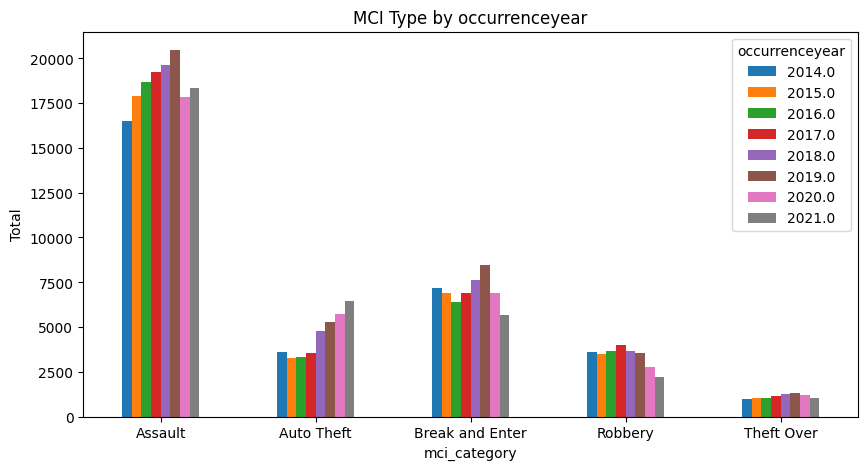

In [47]:
### Exploring the data to gain insigths
### Using pandas crosstab // Feb 24, 2023
data_ct_plot = pd.crosstab(data.mci_category,data.occurrenceyear)
data_ct_plot.plot(kind='bar', stacked=False, rot = 0, figsize=(10, 5));
plt.ylabel('Total')
plt.title('MCI Type by occurrenceyear')

In [48]:
### Exploring the data to gain insigths
### Describe from data_crosstable // Feb 27,2023
data_ct[0:-1].describe()

occurrenceyear        2014.0       2015.0        2016.0        2017.0  \
count               5.000000      5.00000      5.000000      5.000000   
mean            12573.200000  12820.80000  13019.000000  13692.400000   
std             12041.913519  12547.22494  12842.855251  13412.199048   
min              3589.000000   3247.00000   3303.000000   3571.000000   
25%              3623.000000   3478.00000   3646.000000   3985.000000   
50%              7201.000000   6906.00000   6398.000000   6880.000000   
75%             16521.000000  17905.00000  18692.000000  19216.000000   
max             31932.000000  32568.00000  33056.000000  34810.000000   

occurrenceyear        2018.0        2019.0        2020.0        2021.0  \
count               5.000000      5.000000      5.000000      5.000000   
mean            14507.400000  15375.200000  13547.000000  13289.400000   
std             14031.908256  14822.903484  13015.812979  12954.560483   
min              3634.000000   3524.000000   2773.000000   2223.000000   
25%              4785.000000   5304.000000   5726.000000   5648.000000   
50%              7611.000000   8467.000000   6902.000000   6481.000000   
75%             19612.000000  20472.000000  17869.000000  18349.000000   
max             36895.000000  39109.000000  34465.000000  33746.000000   

occurrenceyear            All  
count                5.000000  
mean            108824.400000  
std             105513.867668  
min              26886.000000  
25%              36006.000000  
50%              56013.000000  
75%             148636.000000  
max             276581.000000

In [49]:
### Exploring the data to gain insigths / Kurtosis from data_crosstable // Feb 27,2023
### Is a measure of the "tailedness" of the probability distribution of a real-valued random variable. Like skewness, kurtosis describes a particular aspect of a probability distribution. There are different ways to quantify kurtosis for a theoretical distribution, and there are corresponding ways of estimating it using a sample from a population. Different measures of kurtosis may have different interpretations.
### https://en.wikipedia.org/wiki/Kurtosis
data_ct[0:-1].kurtosis()

occurrenceyear
2014.0    1.181861
2015.0    0.572433
2016.0    0.306167
2017.0    0.549815
2018.0    0.933420
2019.0    1.069322
2020.0    1.188767
2021.0    0.713790
All       0.829051
dtype: float64

In [50]:
### Exploring the data to gain insigths
### Latitue and Longitude int(values) => 43 / -79 // a couple of ZEROS
data[['Latitude','Longitude']]

Latitude  Longitude
0       43.766371 -79.504475
1       43.814861 -79.217083
2       43.589085 -79.534957
3       43.703212 -79.346588
4       43.645247 -79.531916
...           ...        ...
276576  43.717185 -79.372779
276577  43.712045 -79.280963
276578  43.710613 -79.482170
276579  43.706719 -79.245055
276580  43.725396 -79.476408

[276581 rows x 2 columns]

In [51]:
# ### Exploring the data to gain insigths / Histogram for each numerical atribute
# import matplotlib.pyplot as plt
# data.hist(bins=50, figsize=(12,8))
# plt.show()

In [52]:
# ### Exploring the data to gain insigths
# ### Kurtosis from data_crosstable // Feb 27,2023
# for i in range(0, data_ct.shape[0]):
#     print (data_ct.iloc[i, 0:-1])
#     sns.distplot(data_ct.iloc[i, 0:-1])
#     #data_ct.iloc[i, 0:-1].hist(bins=5)
#     plt.show()

## 3.1 MCI Category

In [53]:
### Exploring the data to gain insigths // MCI CATEGORY
### Trying to find data correlation / crosstab // Feb 24, 2023
data_ct_t =  pd.crosstab(data.mci_category, data.occurrenceyear, margins=False).reindex()
data_ct_t = data_ct_t.T
type_corr = data_ct_t.corr()
type_corr

mci_category      Assault  Auto Theft  Break and Enter   Robbery  Theft Over
mci_category                                                                
Assault          1.000000    0.234653         0.468650  0.222266    0.785353
Auto Theft       0.234653    1.000000        -0.094071 -0.816128    0.425330
Break and Enter  0.468650   -0.094071         1.000000  0.542171    0.739795
Robbery          0.222266   -0.816128         0.542171  1.000000    0.129852
Theft Over       0.785353    0.425330         0.739795  0.129852    1.000000

In [54]:
# ### Exploring the data to gain insigths
# ### Trying to find data correlation using sns seaborn // Feb 24, 2023
# plt.figure(figsize=(10,8))
# ax = sns.heatmap(type_corr, annot=True)
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

<!-- Correlations: Only >=0.5

1.   **Assault** has high correlation with **Theft Over** 
2. **Auto Theft** has high correlation with **NONE**
3. **Break and Enter** has correlation with **Roberry** and **Theft Over** 
4. **Robbery** has high correlation with **Break and Enter**
5. **Theft Over** has high correlation with **Assault** and **Break and Enter** -->

In [55]:
### Exploring the data to gain insigths / MCI per year analysis // March 7, 2023
mciYear = data_ct.loc['All']
df_ct = data_ct.iloc[:-1,:]
mciYear = mciYear[:-1]
mciYear

occurrenceyear
2014.0    31932
2015.0    32568
2016.0    33056
2017.0    34810
2018.0    36895
2019.0    39109
2020.0    34465
2021.0    33746
Name: All, dtype: int64

In [56]:
### Exploring the data to gain insigths / MCI per year analysis // March 7, 2023
data_annual = pd.concat([pd.Series(mciYear.index, name='Year'), 
                       pd.Series(mciYear.values, name='Type')], axis=1).reset_index()
data_annual = data_annual.drop(columns=['index'])
data_annual

Year   Type
0  2014.0  31932
1  2015.0  32568
2  2016.0  33056
3  2017.0  34810
4  2018.0  36895
5  2019.0  39109
6  2020.0  34465
7  2021.0  33746

Text(0.5, 1.0, 'Annual Total MCI')

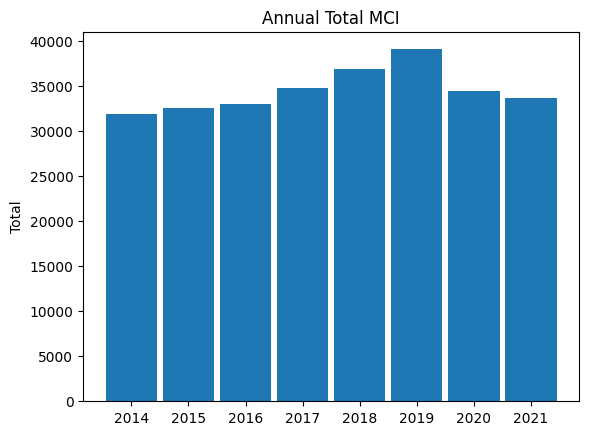

In [57]:
### Exploring the data to gain insigths / MCI per year analysis / Annual Total MCI Bar graph // March 7, 2023
plt.bar('Year', height='Type', width=0.9, align='center', data=data_annual)
plt.ylabel('Total')
plt.title('Annual Total MCI')

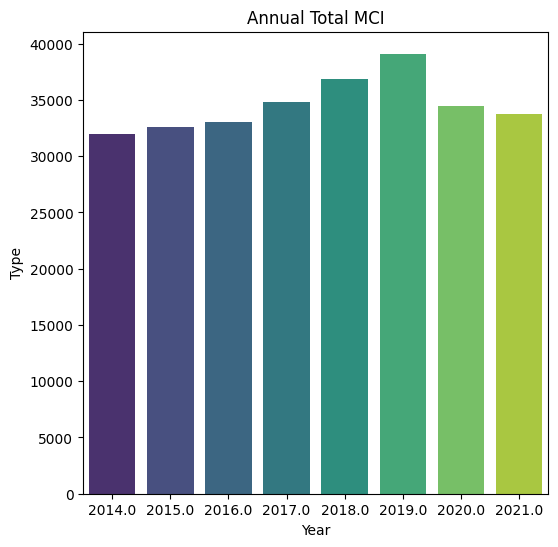

In [58]:
### Exploring the data to gain insigths / MCI per year analysis / Annual Total MCI Line graph // March 7, 2023
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x='Year', y='Type', data=data_annual, palette="viridis")
ax.set_title('Annual Total MCI')
plt.show()

## 3.2 MCI by neighbourhood

In [59]:
### Exploring the data to gain insigths / MCI by neighbourhood // March 7, 2023
data_hood_ct = pd.crosstab(data.Neighbourhood, data.occurrenceyear, margins=True)
data_hood_ct.sort_values("All", axis = 0, ascending = False,inplace = True) 
data_hood_ct.head(6)

occurrenceyear                     2014.0  2015.0  2016.0  2017.0  2018.0  \
Neighbourhood                                                               
All                                 31932   32568   33056   34810   36895   
Waterfront Communities-The Island    1035    1142    1241    1336    1466   
Church-Yonge Corridor                 876     896     943    1168    1319   
Bay Street Corridor                   784     960     949    1182    1160   
West Humber-Clairville                887     818     876     936    1145   
Moss Park                             654     651     734     718     935   

occurrenceyear                     2019.0  2020.0  2021.0     All  
Neighbourhood                                                      
All                                 39109   34465   33746  276581  
Waterfront Communities-The Island    1402    1323    1528   10473  
Church-Yonge Corridor                1458    1240    1431    9331  
Bay Street Corridor                  1342     887     798    8062  
West Humber-Clairville               1014     879     941    7496  
Moss Park                            1086    1156     919    6853

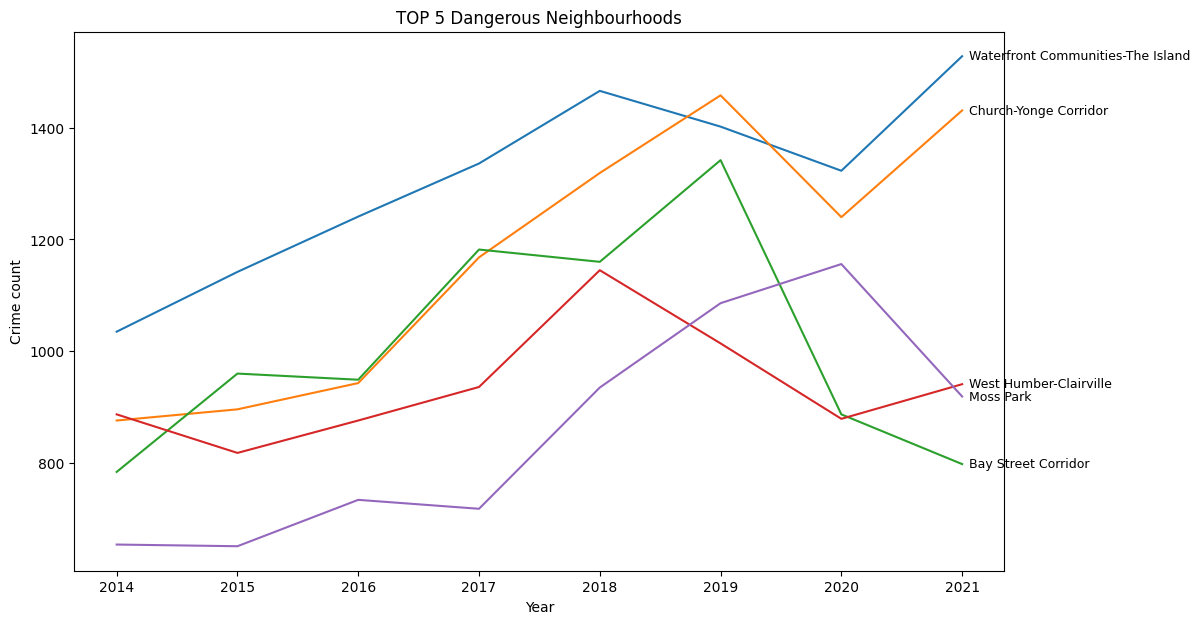

In [60]:
### Exploring the data to gain insigths / MCI by most dangerous neighbourhood // March 7, 2023
top5danger = data_hood_ct.iloc[1:6,:8].T
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.set_title('TOP 5 Dangerous Neighbourhoods')

# Add axis labels
# Add labels for each neighborhood line
for i, column in enumerate(top5danger.columns):
    # Get the last (x, y) coordinates of each line
    x_coord = top5danger.index[-1]
    y_coord = top5danger[column].iloc[-1]
    
    # Add the neighborhood name as label at the end of each line
    ax.annotate(column, (x_coord, y_coord), textcoords="offset points", xytext=(5, 0), ha='left', va='center', fontsize=9)


ax.set_xlabel("Year")
ax.set_ylabel("Crime count")
ax.plot(top5danger)

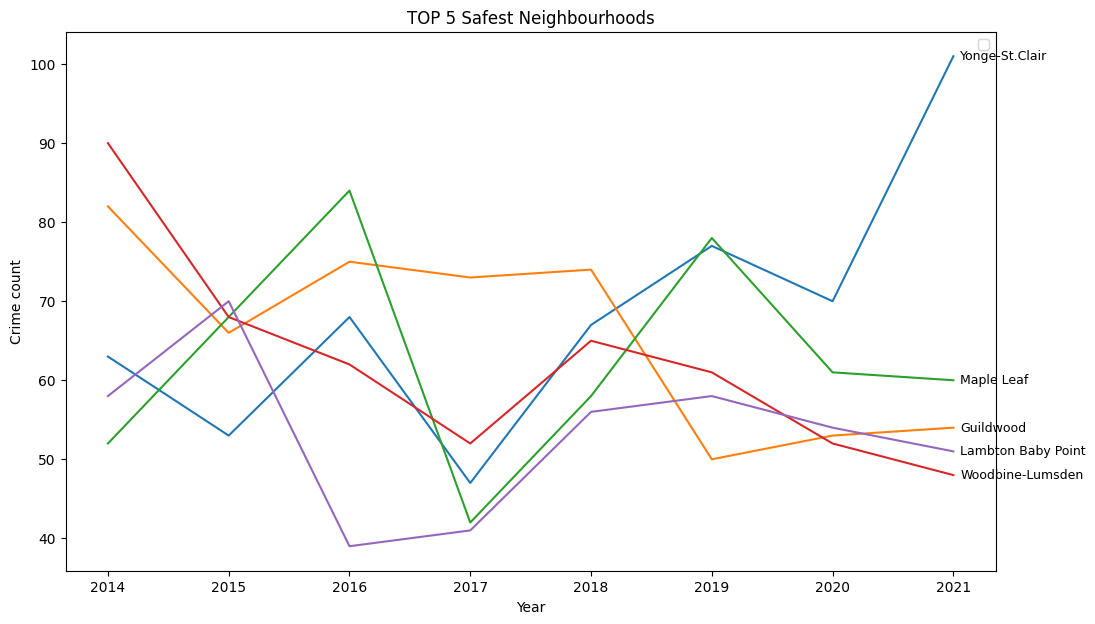

In [61]:
### Exploring the data to gain insigths 
### MCI by most dangerous neighbourhood // March 7, 2023
top5safe = data_hood_ct.iloc[-5:,:8].T
fig, ax = plt.subplots(1,1,figsize=(12,7))

ax.set_title('TOP 5 Safest Neighbourhoods')

# Add labels for each neighborhood line
for i, column in enumerate(top5safe.columns):
    # Get the last (x, y) coordinates of each line
    x_coord = top5safe.index[-1]
    y_coord = top5safe[column].iloc[-1]
    
# Add labels for each neighborhood line
for i, column in enumerate(top5safe.columns):
    # Get the last (x, y) coordinates of each line
    x_coord = top5safe.index[-1]
    y_coord = top5safe[column].iloc[-1]
    
    # Add the neighborhood name as label at the end of each line
    ax.annotate(column, (x_coord, y_coord), textcoords="offset points", xytext=(5, 0), ha='left', va='center', fontsize=9)
# Add axis labels
ax.legend(top5safe.columns.to_list(), loc="best", bbox_to_anchor = (1,1))
ax.set_xlabel("Year")
ax.set_ylabel("Crime count")
ax.plot(top5safe)

In [62]:
### Exploring the data to gain insigths
### MCI by safest neighbourhood // March 7, 2023
data_hood_ct.tail(5)

occurrenceyear      2014.0  2015.0  2016.0  2017.0  2018.0  2019.0  2020.0  \
Neighbourhood                                                                
Yonge-St.Clair          63      53      68      47      67      77      70   
Guildwood               82      66      75      73      74      50      53   
Maple Leaf              52      68      84      42      58      78      61   
Woodbine-Lumsden        90      68      62      52      65      61      52   
Lambton Baby Point      58      70      39      41      56      58      54   

occurrenceyear      2021.0  All  
Neighbourhood                    
Yonge-St.Clair         101  546  
Guildwood               54  527  
Maple Leaf              60  503  
Woodbine-Lumsden        48  498  
Lambton Baby Point      51  427

## 3.3 Most dangerous hours


In [63]:
### Exploring the data to gain insigths 
### MCI by hour of the day // March 21, 2023
data_hourly_ct = pd.crosstab(data.mci_category, data.occurrencehour, margins=False)
#data_hourly_ct = pd.crosstab(data.occurrencehour, data.mci_category,margins=False)
data_hourly_ct.head()

occurrencehour     0     1     2     3     4     5     6     7     8     9   \
mci_category                                                                  
Assault          9604  6195  6394  4273  2729  2024  2073  2726  4182  5001   
Auto Theft       2298  1203   961   795   683   616   673   898   920   973   
Break and Enter  4175  2474  2547  2850  2815  2298  1607  1684  2322  2399   
Robbery          1423  1391  1139   926   609   403   355   255   303   402   
Theft Over        931   188   176   146   119    99   103   153   238   453   

occurrencehour   ...    14    15    16    17    18    19    20    21    22  \
mci_category     ...                                                         
Assault          ...  6790  8172  7547  7849  8177  7855  7927  7869  7424   
Auto Theft       ...  1083  1147  1485  1817  2313  2318  2714  2877  3203   
Break and Enter  ...  2106  2015  2028  2325  2510  2215  2016  1987  1962   
Robbery          ...  1121  1670  1513  1472  1527  1657  1858  1974  1850   
Theft Over       ...   480   493   492   568   534   442   420   374   312   

occurrencehour     23  
mci_category           
Assault          7454  
Auto Theft       2866  
Break and Enter  2163  
Robbery          1706  
Theft Over        301  

[5 rows x 24 columns]

Text(0, 0.5, 'Crime count')

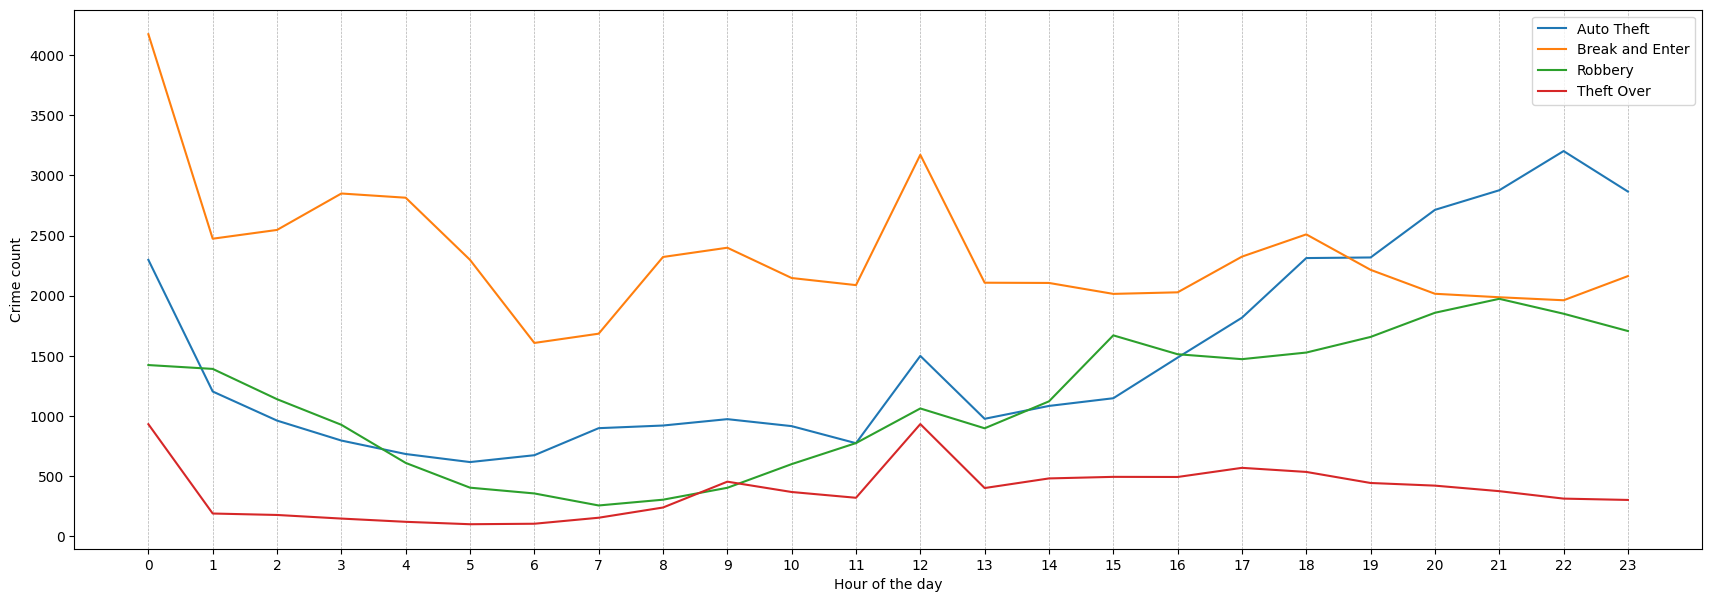

In [64]:
### Exploring the data to gain insigths 
### MCI by hour of the day // March 21, 2023
hourly_analysis = data_hourly_ct.iloc[1:23].T
fig, ax = plt.subplots(1,1,figsize=(21,7))
ax.plot(hourly_analysis)

# Set x-axis ticks and enable grid
ax.set_xticks(range(24))
ax.grid(axis='x', linestyle='--', linewidth=0.5)

# Add axis labels
ax.legend(hourly_analysis.columns.to_list(), loc="best", bbox_to_anchor = (1,1))
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Crime count")

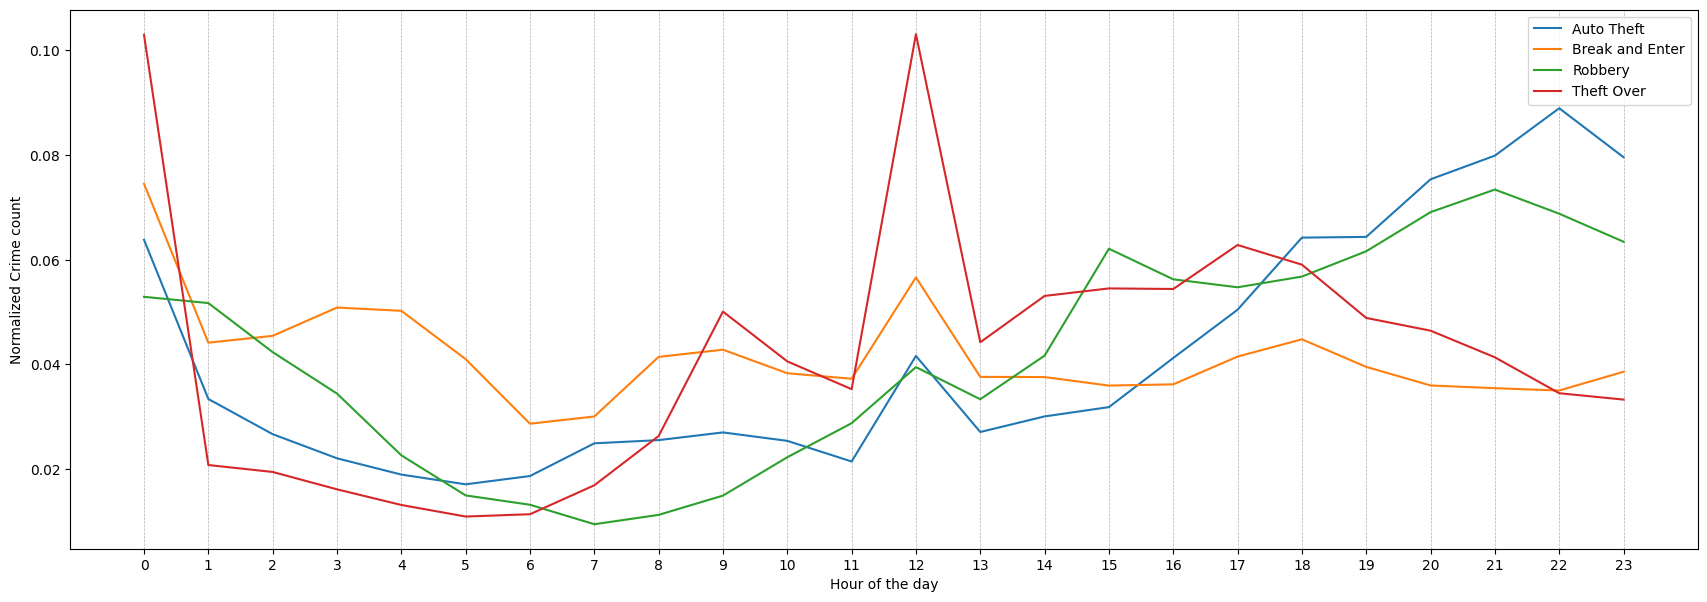

In [65]:
# Normalize data_hourly_ct
data_hourly_ct_normalized = data_hourly_ct.div(data_hourly_ct.sum(axis=1), axis=0)

# Create hourly_analysis DataFrame with normalized data
hourly_analysis_normalized = data_hourly_ct_normalized.iloc[1:23].T

# Plot the normalized data
fig, ax = plt.subplots(1, 1, figsize=(21, 7))
ax.plot(hourly_analysis_normalized)

# Set x-axis ticks and enable grid
ax.set_xticks(range(24))
ax.grid(axis='x', linestyle='--', linewidth=0.5)

# Add axis labels
ax.legend(hourly_analysis_normalized.columns.to_list(), loc="best", bbox_to_anchor=(1, 1))
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Normalized Crime count")
plt.show()

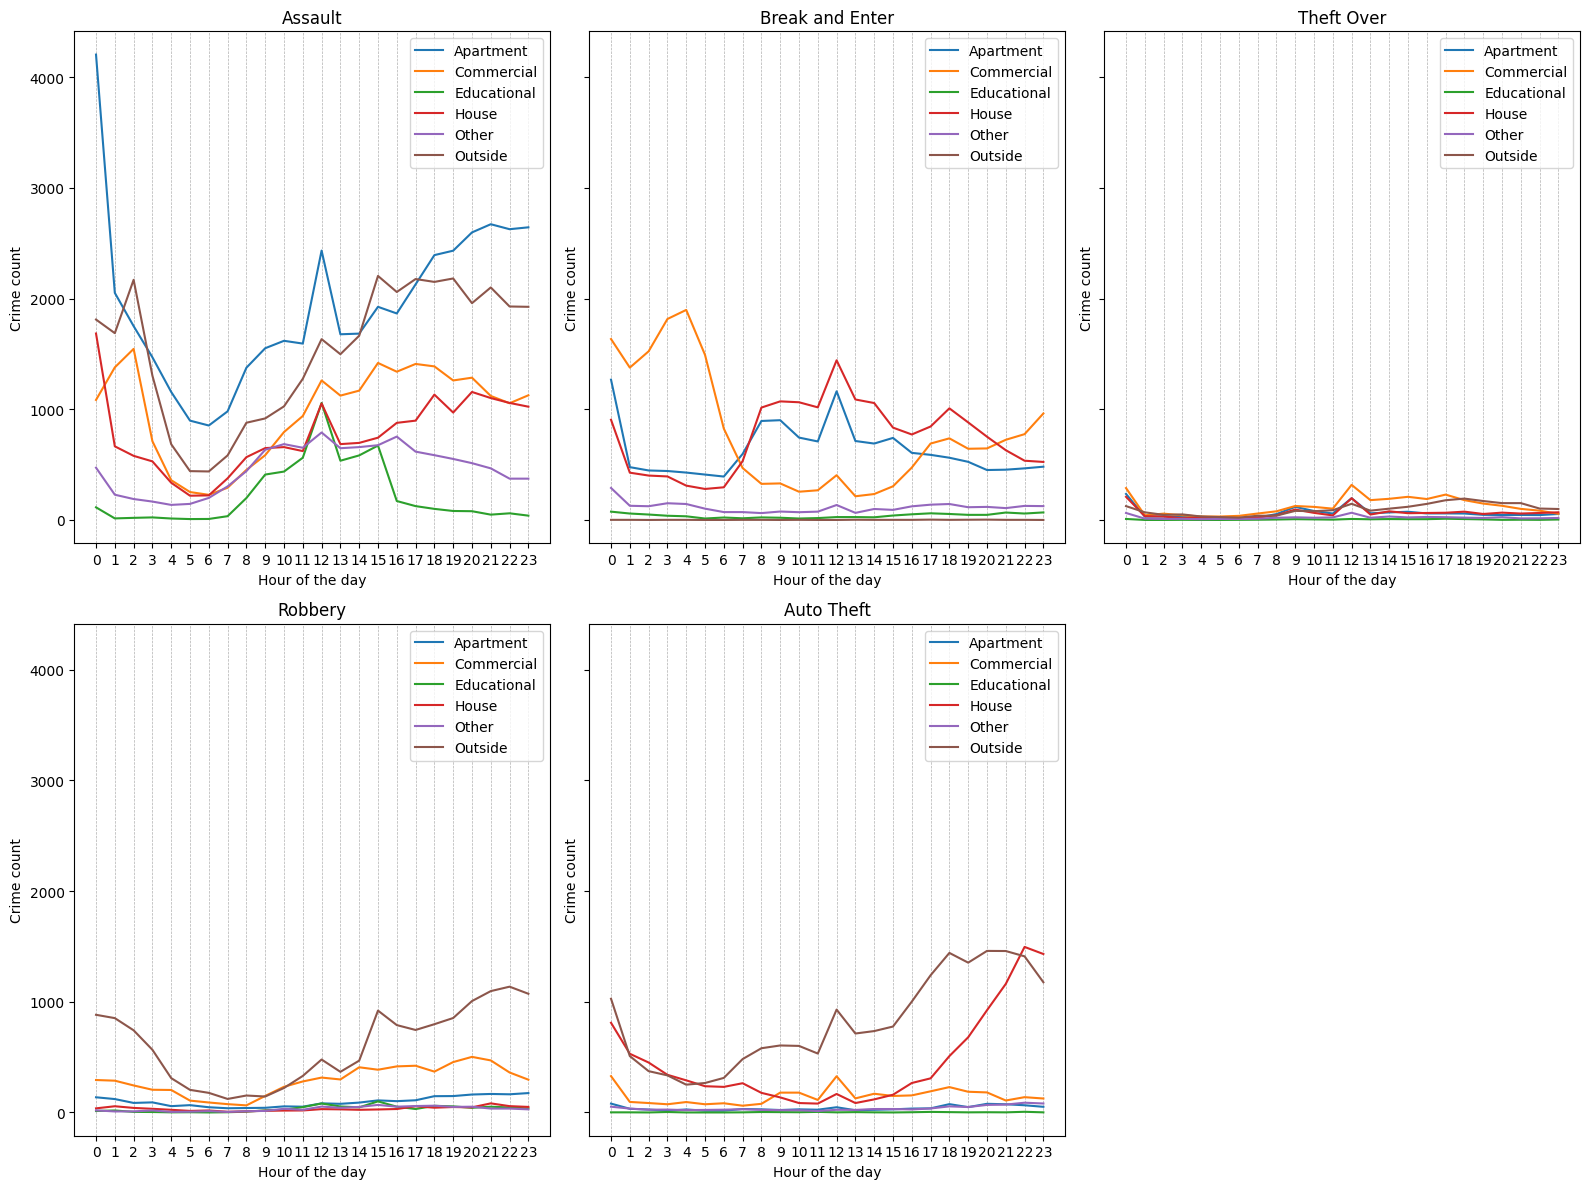

In [66]:
data_hourly_ct = pd.crosstab(data.mci_category, data.occurrencehour, margins=False)

fig, axs = plt.subplots(2, 3, figsize=(16,12), sharey=True)

for i, ax in enumerate(axs.flatten()):
    if i < 5:
        mci_category = data.mci_category.unique()[i]
        subset = data[data['mci_category'] == mci_category]
        premises_type_ct = pd.crosstab(subset.occurrencehour, subset.premises_type, margins=False)
        premises_type_analysis = premises_type_ct.iloc[:, :-1]
        ax.plot(premises_type_analysis)
        ax.set_title(mci_category)
        ax.set_xticks(range(24))
        ax.grid(axis='x', linestyle='--', linewidth=0.5)
        ax.legend(premises_type_analysis.columns.to_list(), loc="best", bbox_to_anchor=(1,1))
        ax.set_xlabel("Hour of the day")
        ax.set_ylabel("Crime count")
        #plt.subplots_adjust(hspace=0.4, wspace=0.2)
        
    else:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()


<ipython-input-67-f565e8110faa>:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


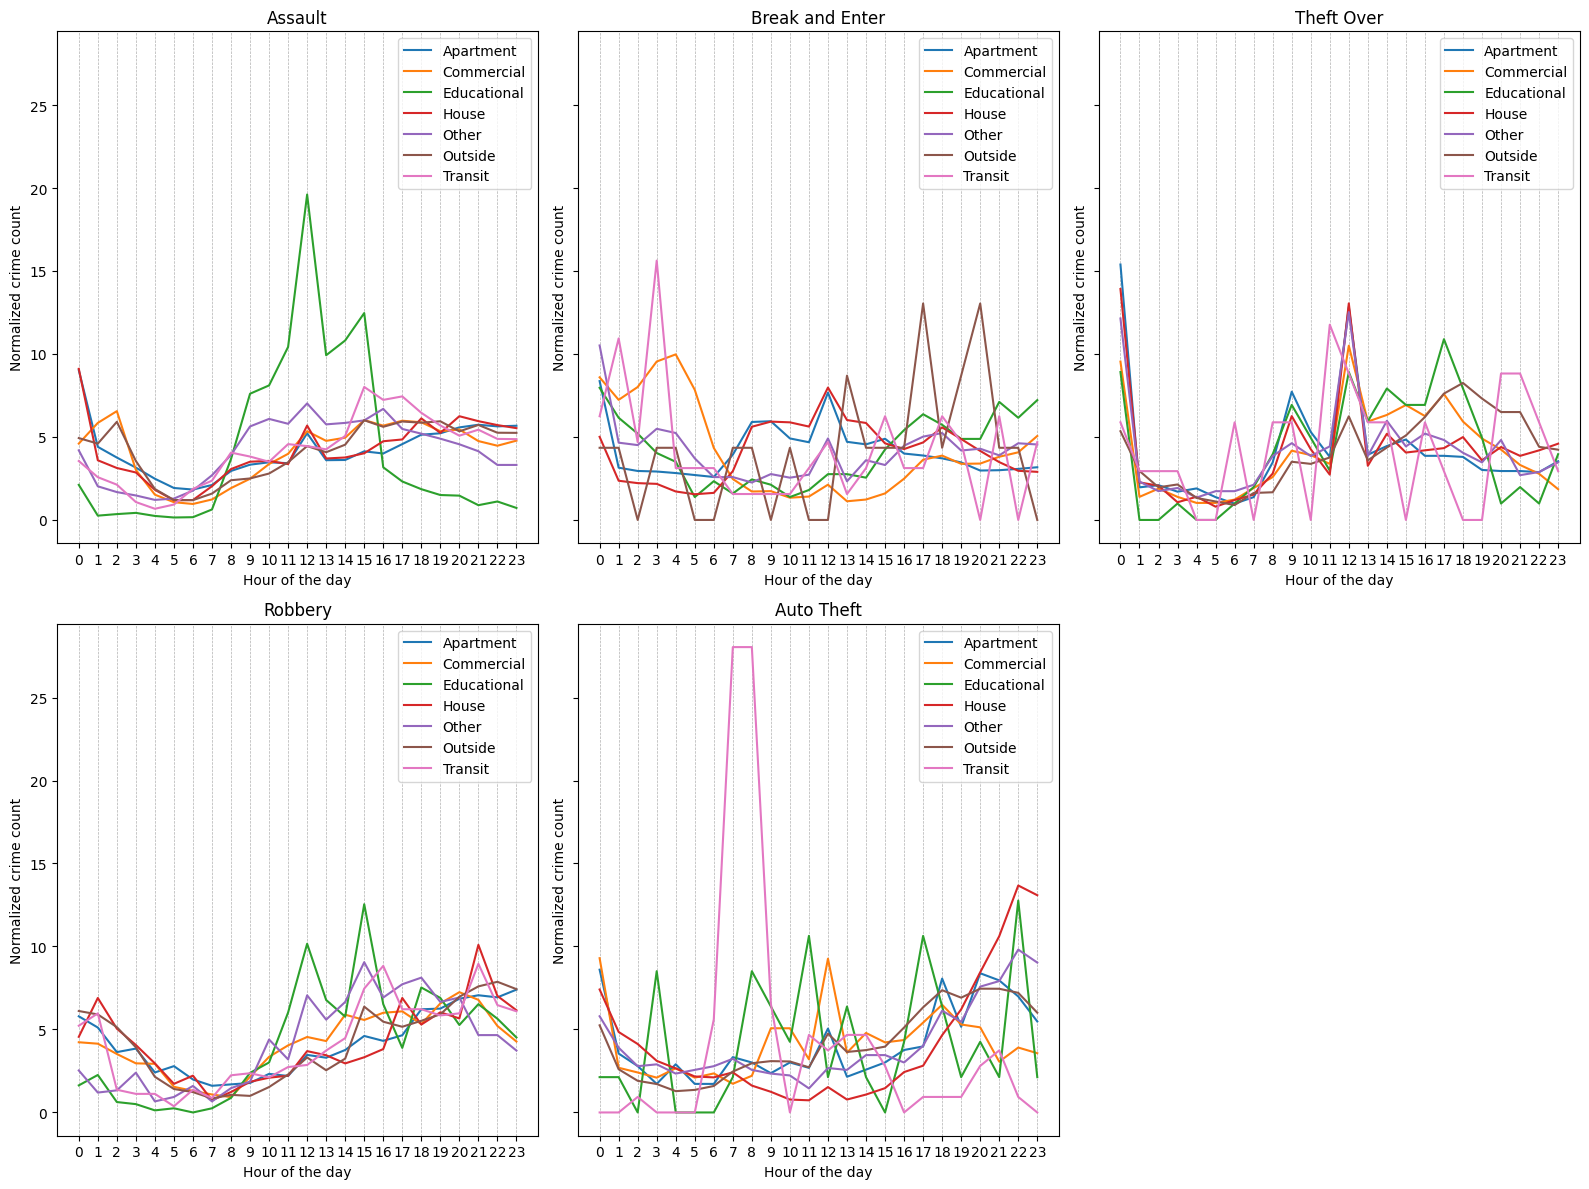

In [67]:
import matplotlib.gridspec as gridspec

data_hourly_ct = pd.crosstab(data.mci_category, data.occurrencehour, margins=False)

fig, axs = plt.subplots(2, 3, figsize=(16,12), sharey=True,constrained_layout=True,)
gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig, height_ratios=[1.5, 1])
for i, ax in enumerate(axs.flatten()):
    if i < 5:
        mci_category = data.mci_category.unique()[i]
        subset = data[data['mci_category'] == mci_category]
        premises_type_ct = pd.crosstab(subset.occurrencehour, subset.premises_type, margins=False)
        premises_type_analysis = premises_type_ct.apply(lambda x: x/x.sum()*100, axis=0) # normalize the data
        ax.plot(premises_type_analysis)
        ax.set_title(mci_category)
        ax.set_xticks(range(24))
        ax.grid(axis='x', linestyle='--', linewidth=0.5)
        ax.legend(premises_type_analysis.columns.to_list(), loc="best", bbox_to_anchor=(1,1))
        ax.set_xlabel("Hour of the day")
        # ax.xaxis.set_label_coords(0.5, -0.0)
        ax.set_ylabel("Normalized crime count")
        
    else:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()


## 3.4 Most Dangerous days of the week

In [68]:
### Exploring the data to gain insigths / MCI by day of the week // March 21, 2023
data_wdays_ct = pd.crosstab(data.mci_category, data.occurrencedayofweek, margins=False)

# Remove whitespace from column names
data_wdays_ct.columns = data_wdays_ct.columns.str.strip()

# weekdays in order
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data_wdays_ct = data_wdays_ct[weekdays]
data_wdays_ct.head()

occurrencedayofweek  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  \
mci_category                                                                  
Assault               20133    19514      20506     20115   21594     23466   
Auto Theft             5062     5189       5425      5389    5452      4767   
Break and Enter        8123     7943       8053      8223    9223      7520   
Robbery                3723     3712       3788      3785    4184      4147   
Theft Over             1329     1332       1332      1344    1533      1150   

occurrencedayofweek  Sunday  
mci_category                 
Assault               23308  
Auto Theft             4722  
Break and Enter        6928  
Robbery                3547  
Theft Over             1020

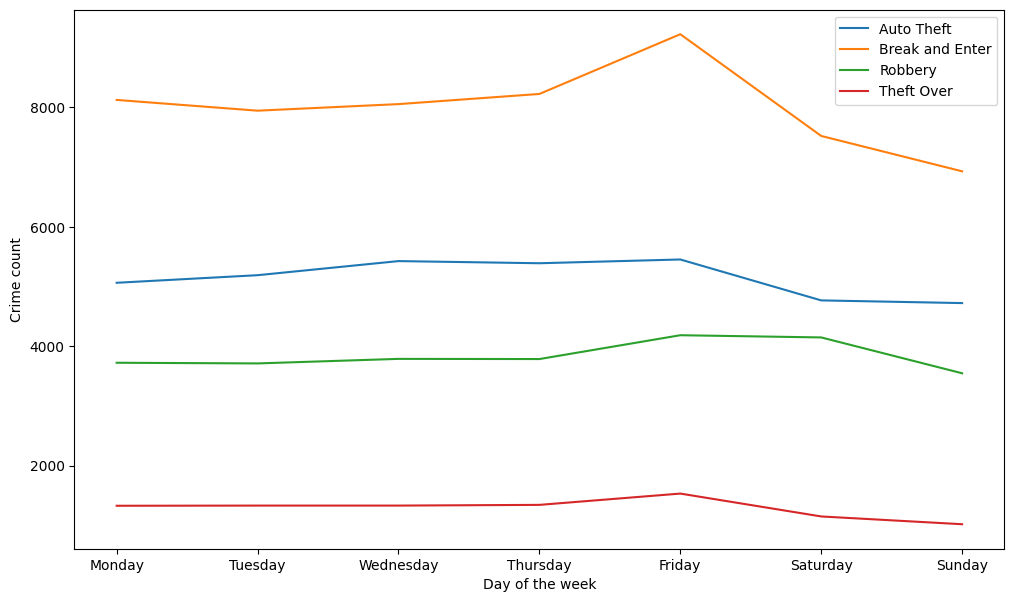

In [69]:
### Exploring the data to gain insigths / MCI by day of the week // March 21, 2023
wdays_analysis = data_wdays_ct.iloc[1:23].T
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(wdays_analysis)
ax.legend(wdays_analysis.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

# Add axis labels
ax.legend(wdays_analysis.columns.to_list(), loc="best", bbox_to_anchor = (1,1))
ax.set_xlabel("Day of the week")
ax.set_ylabel("Crime count")
plt.show()

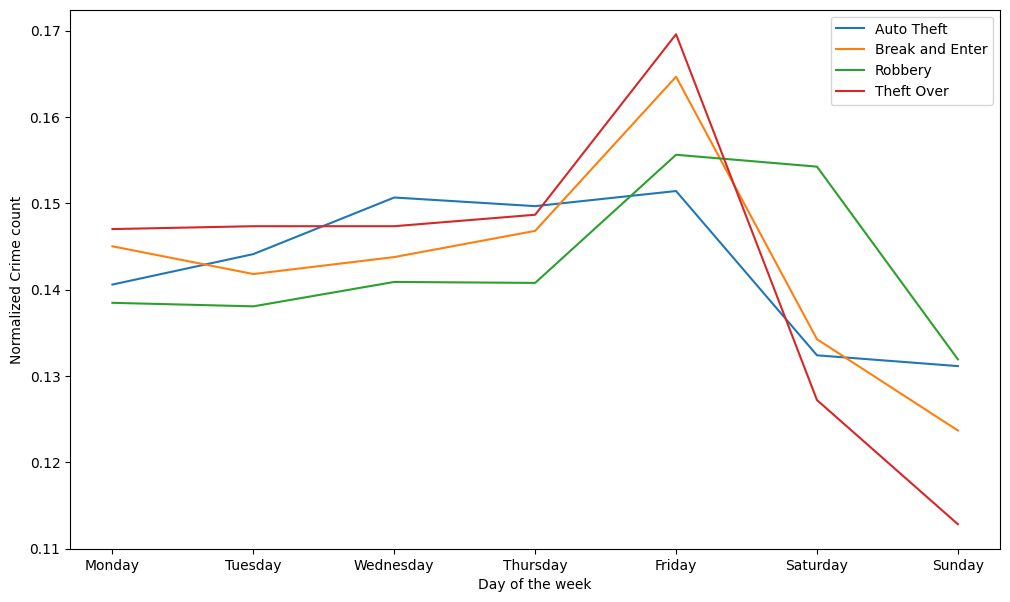

In [70]:
# Normalize data_wdays_ct
data_wdays_ct_normalized = data_wdays_ct.div(data_wdays_ct.sum(axis=1), axis=0)

# Create wdays_analysis DataFrame with normalized data
wdays_analysis_normalized = data_wdays_ct_normalized.iloc[1:23].T

# Plot the normalized data
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(wdays_analysis_normalized)

# Add axis labels
ax.legend(wdays_analysis_normalized.columns.to_list(), loc="best", bbox_to_anchor=(1, 1))
ax.set_xlabel("Day of the week")
ax.set_ylabel("Normalized Crime count")

plt.show()

## 3.5 Most dangerous months 

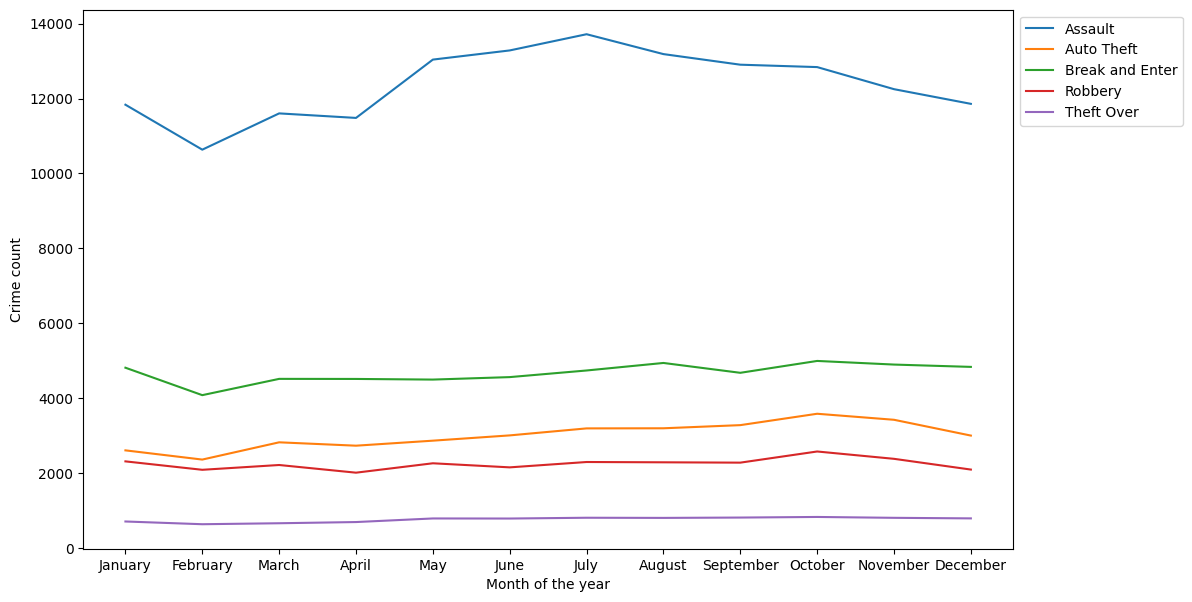

In [71]:
### Exploring the data to gain insigths / MCI by month of the year // March 21, 2023
data_monthly_ct = pd.crosstab(data.mci_category, data.occurrencemonth, margins=False)
data_monthly_ct=data_monthly_ct[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

monthly_analysis = data_monthly_ct.T

# Plot
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(monthly_analysis)
ax.legend(monthly_analysis.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

# Add axis labels
ax.legend(monthly_analysis.columns.to_list(), loc="best", bbox_to_anchor = (1,1))
ax.set_xlabel("Month of the year")
ax.set_ylabel("Crime count")
plt.show()

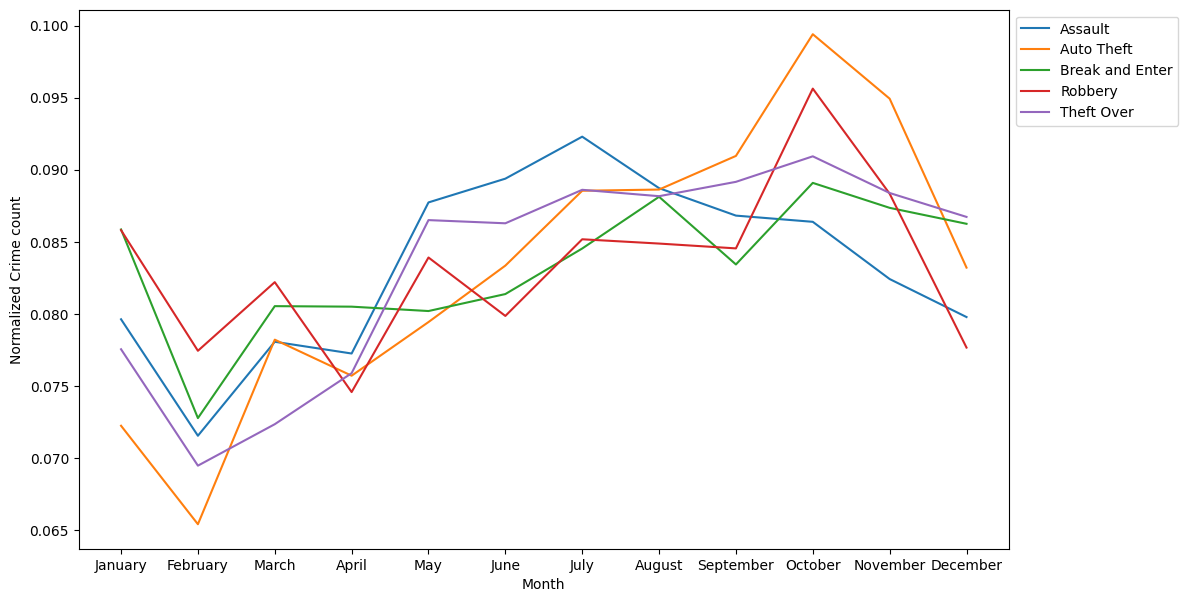

In [72]:
# Normalize data_monthly_ct
data_monthly_ct_normalized = data_monthly_ct.div(data_monthly_ct.sum(axis=1), axis=0)

# Create monthly_analysis DataFrame with normalized data
monthly_analysis_normalized = data_monthly_ct_normalized.T

# Plot the normalized data
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(monthly_analysis_normalized)

# Add axis labels
ax.legend(monthly_analysis_normalized.columns.to_list(), loc="best", bbox_to_anchor=(1, 1))
ax.set_xlabel("Month")
ax.set_ylabel("Normalized Crime count")

plt.show()

In [73]:
# ### Exploring the data to gain insigths
# ### Trying to find data correlation using sns seaborn // March 21, 2023
# data_ct_t =  pd.crosstab(data.mci_category, data.occurrencedayofweek, margins=False).reindex()
# data_ct_t = data_ct_t.T
# type_corr = data_ct_t.corr()
# type_corr

In [74]:
# plt.figure(figsize=(10,8))
# ax = sns.heatmap(type_corr, annot=True)
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

In [75]:
# ### Exploring the data to gain insigths
# ### Trying to find data correlation using sns seaborn // March 21, 2023
# data_ct_t =  pd.crosstab(data.occurrencedayofweek, data.mci_category, margins=False).reindex()
# data_ct_t = data_ct_t.T
# type_corr = data_ct_t.corr()
# type_corr

In [76]:
# plt.figure(figsize=(10,8))
# ax = sns.heatmap(type_corr, annot=True)
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

3.5 Most dangerous holidays

## 3.6 Latitute and Longitude 

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


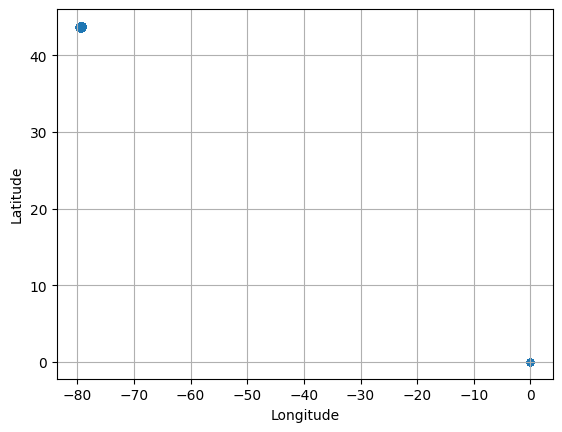

In [77]:
### Exploring the data to gain insigths / Visualizing Goegraphical Data
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [78]:
### Clean the data (68)
### Get rid of the instance / Get rid of the whole attribute / Set the missing values to some value (zero, median, mean, etc.)
### Panda's dataframe > dropna(), drop(), fillna() + Scikit-Learn SimpleImputer
### Solving the issue with Latitude and Longitude - ZERO VALUES

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


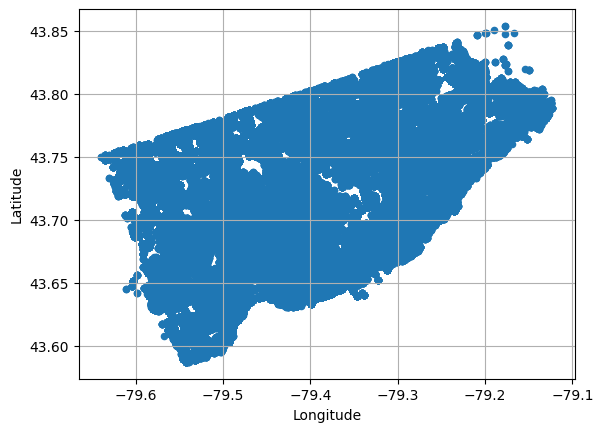

In [79]:
### Replace ZERO values for NaN = "Not a Number"
### data.replace(0, np.nan, inplace=True) ### To replace all the columns
cols = ["Latitude","Longitude"]
data[cols] = data[cols].replace(['0', 0], np.nan)
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

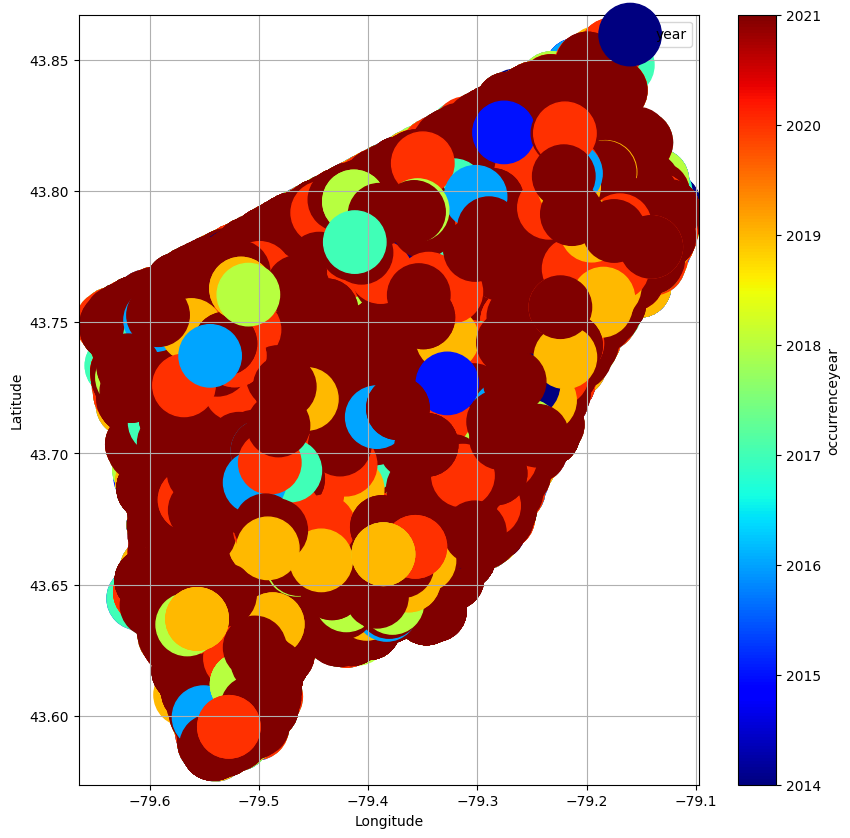

In [80]:
### Exploring the data to gain insigths / Ploting Latitude + Longitude to visualize the data
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, 
          s=data["occurrenceyear"], label = "year",
          c="occurrenceyear", cmap="jet", colorbar=True, 
          legend=True, sharex=False, figsize=(10,10))
plt.show()

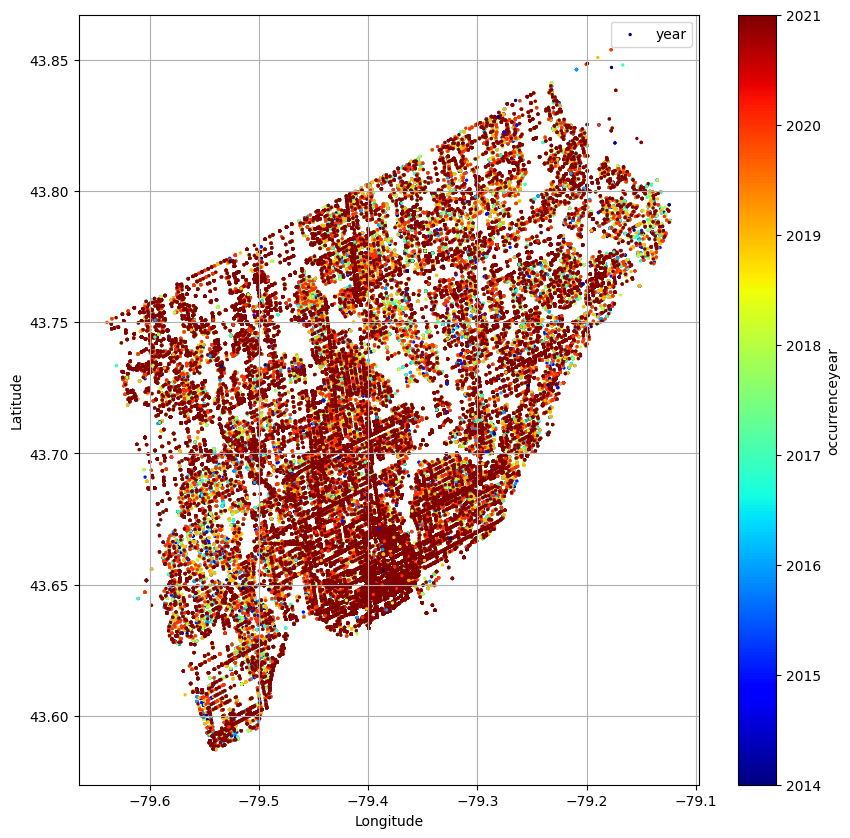

In [81]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, 
          s=2, label = "year",
          c="occurrenceyear", cmap="jet", colorbar=True, 
          legend=True, sharex=False, figsize=(10,10))
plt.show()

In [82]:
# ### Exploring the data to gain insigths / Looking for correlations - using pandas Scatter Matrix
# ### Scatter Matrix plots every numerical atribute against every other attribite, plus a histogram of each numerical atribute's value on the main diagonal top left to bottom rigth 
# from pandas.plotting import scatter_matrix
# attributes = ["ucr_code", "ucr_ext", "occurrenceyear", "reportedyear", "occurrenceday", "occurrencehour", "reportedhour"]
# scatter_matrix(data[attributes], figsize=(12,8))
# plt.show()

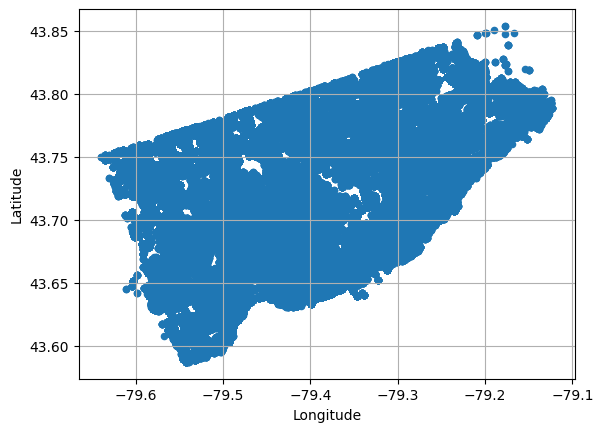

In [83]:
### Exploring the data to gain insigths
### Experiments - Attribute combinations (66)
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [84]:
### Exploring the data to gain insigths / Looking for correlations
corr_matrix = data.corr()
corr_matrix ["ucr_code"].sort_values(ascending=False)

ucr_code               1.000000
ucr_ext                0.920074
surface_km2            0.087691
Latitude               0.042619
occurrenceyear         0.031728
Index_                 0.028373
ObjectId               0.028363
reportedyear           0.026322
occurrencedayofyear    0.014739
occurrenceday          0.010717
reporteddayofyear      0.009992
Y                      0.005449
reportedday            0.000491
X                     -0.006694
pop_2016              -0.033745
occurrencehour        -0.041448
pop_change_11-16      -0.060388
reportedhour          -0.072058
Hood_ID               -0.074562
Longitude             -0.079204
density_per_km2       -0.095832
Name: ucr_code, dtype: float64

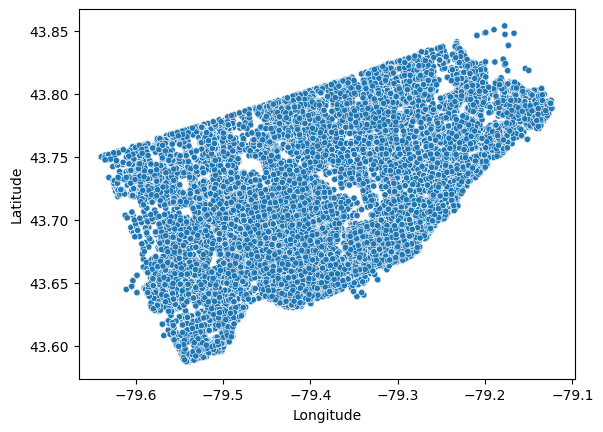

In [85]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
graph = data.loc[data.Neighbourhood == 2015]
sns.scatterplot(data=data, x="Longitude", y="Latitude", size=1, legend=False, sizes=(20, 2000))
plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.9/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


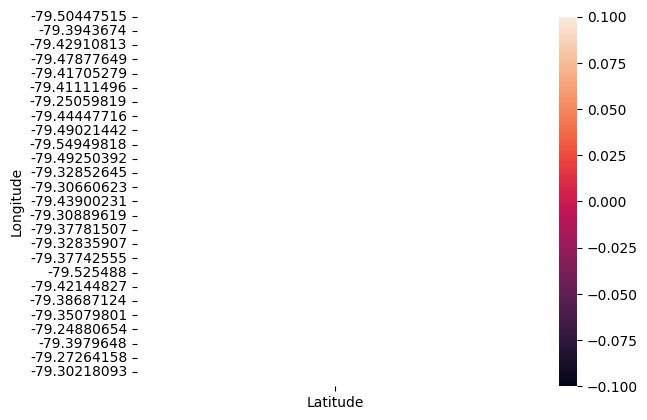

In [86]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
graph2 = pd.DataFrame(data['Latitude'], data['Longitude'])
p1 = sns.heatmap(graph2)

## 3.7 Toronto Map + Merging data
Merging data with aditional dataset
Download shape file to use for the Toronto Map // March 8, 2023
https://open.toronto.ca/dataset/neighbourhoods/
field	name / description 
FIELD_1	_id                    FIELD_2	AREA_ID           FIELD_3	AREA_ATTR_ID
FIELD_4	PARENT_AREA_ID         FIELD_5	AREA_SHORT_CODE   FIELD_6	AREA_LONG_CODE
FIELD_7	AREA_NAME              FIELD_8	AREA_DESC         FIELD_9	CLASSIFICATION
FIELD_10 CLASSIFICATION_CODE   FIELD_11 OBJECTID          geometry	geometry

In [87]:
### Tutorial -> Create a geographic heat map of the City of Toronto in Python // March 8, 2023
### https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55
!pip install geopandas
import geopandas as gpd
sns.set(style="darkgrid")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.9 MB/s eta 0:00:00


In [88]:
### Exploring the data to gain insigths / Group by 'Hood_ID','Neighbourhood' and count // March 8, 2023
data_gp = data.groupby(['Hood_ID','Neighbourhood']).count()[['premises_type']]
data_gp= data_gp.reset_index()
data_gp

Hood_ID                      Neighbourhood  premises_type
0          1             West Humber-Clairville           7496
1          2  Mount Olive-Silverstone-Jamestown           3332
2          3       Thistletown-Beaumond Heights            978
3          4                    Rexdale-Kipling           1072
4          5                   Elms-Old Rexdale            879
..       ...                                ...            ...
135      136                          West Hill           4539
136      137                             Woburn           4989
137      138                      Eglinton East           2429
138      139                Scarborough Village           1968
139      140                          Guildwood            527

[140 rows x 3 columns]

In [89]:
### Exploring the data to gain insigths / Group by 'Hood_ID','Neighbourhood' and count // March 8, 2023
data['count'] = 1
dataByNeighbourhood = data.groupby('Neighbourhood').count()[['count']].reset_index()
dataByNeighbourhood['Neighbourhood'] = dataByNeighbourhood['Neighbourhood'].str.lower()
dataByNeighbourhood.sort_values('count', ascending=False).head(5)

Neighbourhood  count
122  waterfront communities-the island  10473
23               church-yonge corridor   9331
6                  bay street corridor   8062
124             west humber-clairville   7496
79                           moss park   6853

In [90]:
dataByNeighbourhood.head(5)

Neighbourhood  count
0               agincourt north   1480
1  agincourt south-malvern west   2180
2                     alderwood    758
3                         annex   4358
4             banbury-don mills   1552

In [91]:
### Download shape file to use for the Toronto Map // March 8, 2023
### https://open.toronto.ca/dataset/neighbourhoods/
### field	name / description 
### FIELD_1	_id                    FIELD_2	AREA_ID           FIELD_3	AREA_ATTR_ID
### FIELD_4	PARENT_AREA_ID         FIELD_5	AREA_SHORT_CODE   FIELD_6	AREA_LONG_CODE
### FIELD_7	AREA_NAME              FIELD_8	AREA_DESC         FIELD_9	CLASSIFICATION
### FIELD_10 CLASSIFICATION_CODE   FIELD_11 OBJECTID          geometry	geometry
#regions = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Neighbourhoods.shp')


regions = gpd.read_file('Neighbourhoods.shp')
regions.sample(1)

FIELD_1  FIELD_2   FIELD_3  FIELD_4  FIELD_5  FIELD_6      FIELD_7  \
92       93  2502274  26022789      NaN       63       63  The Beaches   

             FIELD_8                               FIELD_9 FIELD_10  FIELD_11  \
92  The Beaches (63)  Not an NIA or Emerging Neighbourhood      NaN  17826209   

                                             geometry  
92  POLYGON ((-79.28122 43.67395, -79.28119 43.673...

In [92]:
regions.shape

(158, 12)

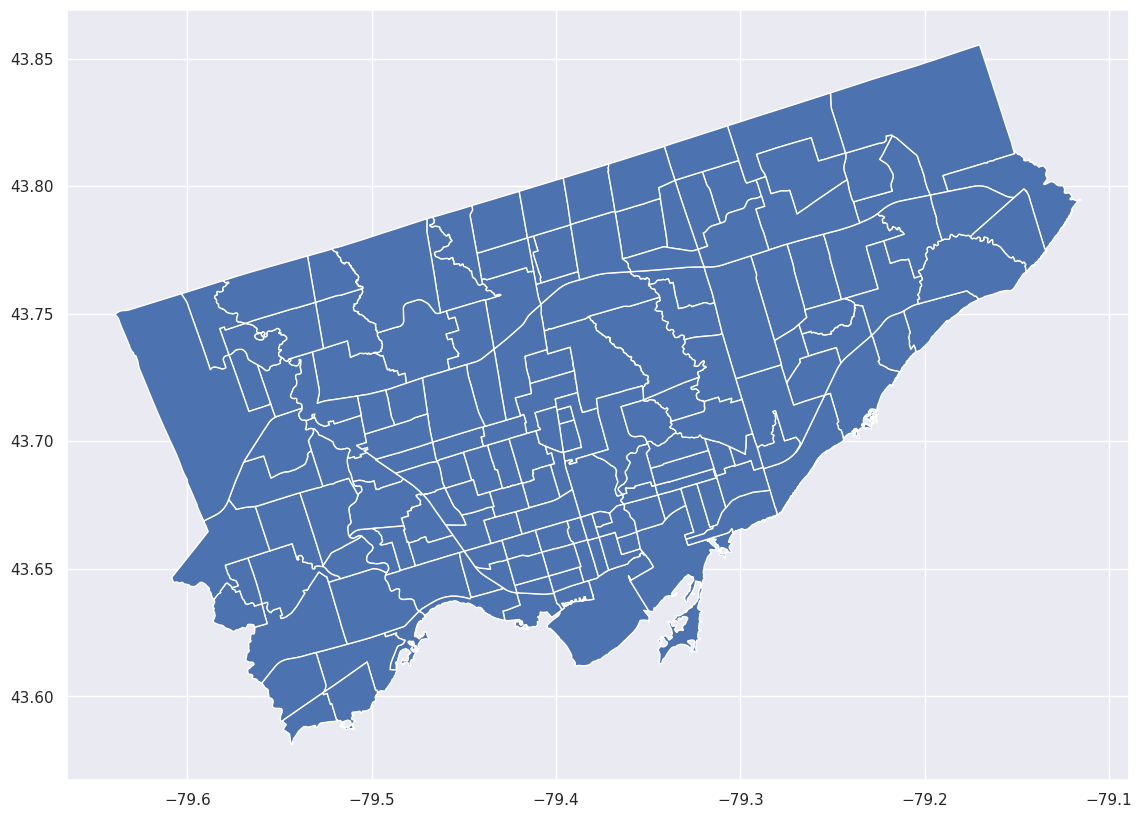

In [93]:
### Plot the data based on the downloaded shape file - Toronto Map // March 8, 2023
### https://open.toronto.ca/dataset/neighbourhoods/
regions.plot(figsize=(20,10))
plt.show()

In [94]:
regions['FIELD_7'] = regions['FIELD_7'].str.lower()
merged = regions.set_index('FIELD_7').join(dataByNeighbourhood.set_index('Neighbourhood'))
merged = merged.reset_index()
merged = merged.fillna(0)
merged[['FIELD_7', 'geometry', 'count']].sample(1)

FIELD_7                                           geometry   count
137  long branch  POLYGON ((-79.52647 43.60117, -79.52623 43.600...  1028.0

In [95]:
merged.shape

(158, 13)

In [96]:
merged.head(1)

FIELD_7  FIELD_1  FIELD_2   FIELD_3  FIELD_4  FIELD_5  \
0  south eglinton-davisville        1  2502366  26022881      0.0      174   

   FIELD_6                          FIELD_8  \
0      174  South Eglinton-Davisville (174)   

                                FIELD_9 FIELD_10  FIELD_11  \
0  Not an NIA or Emerging Neighbourhood        0  17824737   

                                            geometry  count  
0  POLYGON ((-79.38635 43.69783, -79.38623 43.697...    0.0

Text(0.5, 1.0, 'Heat Map of Crimes by Neighbourhood in Toronto, Ontario')

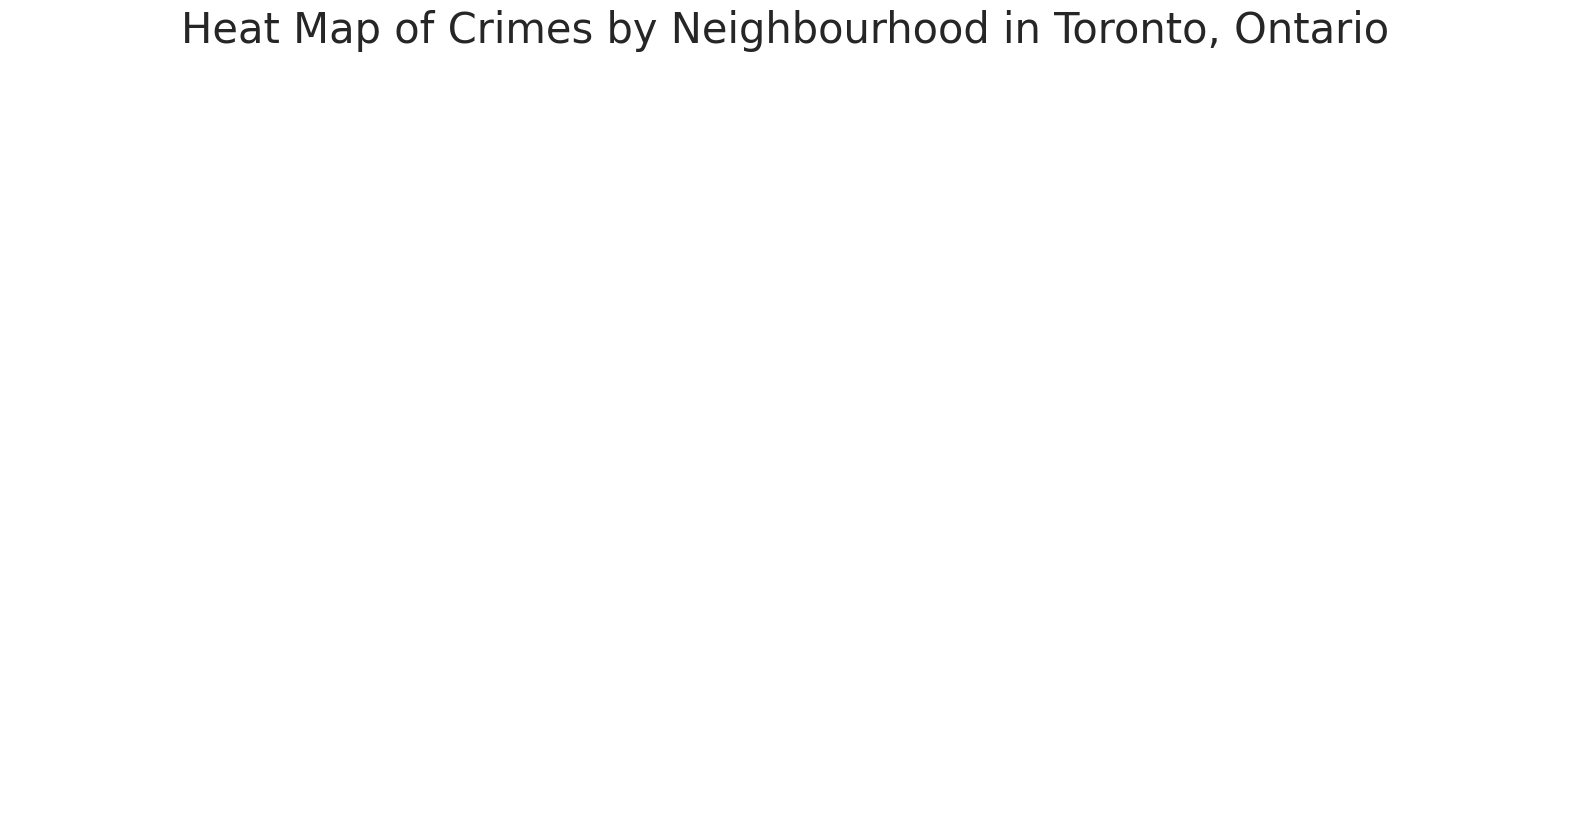

In [97]:
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.axis('off')
ax.set_title('Heat Map of Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '30', 'fontweight' : '3'})

<ipython-input-98-2bd714517414>:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


<Axes: title={'center': 'Heat Map of Crimes by Neighbourhood in Toronto, Ontario'}>

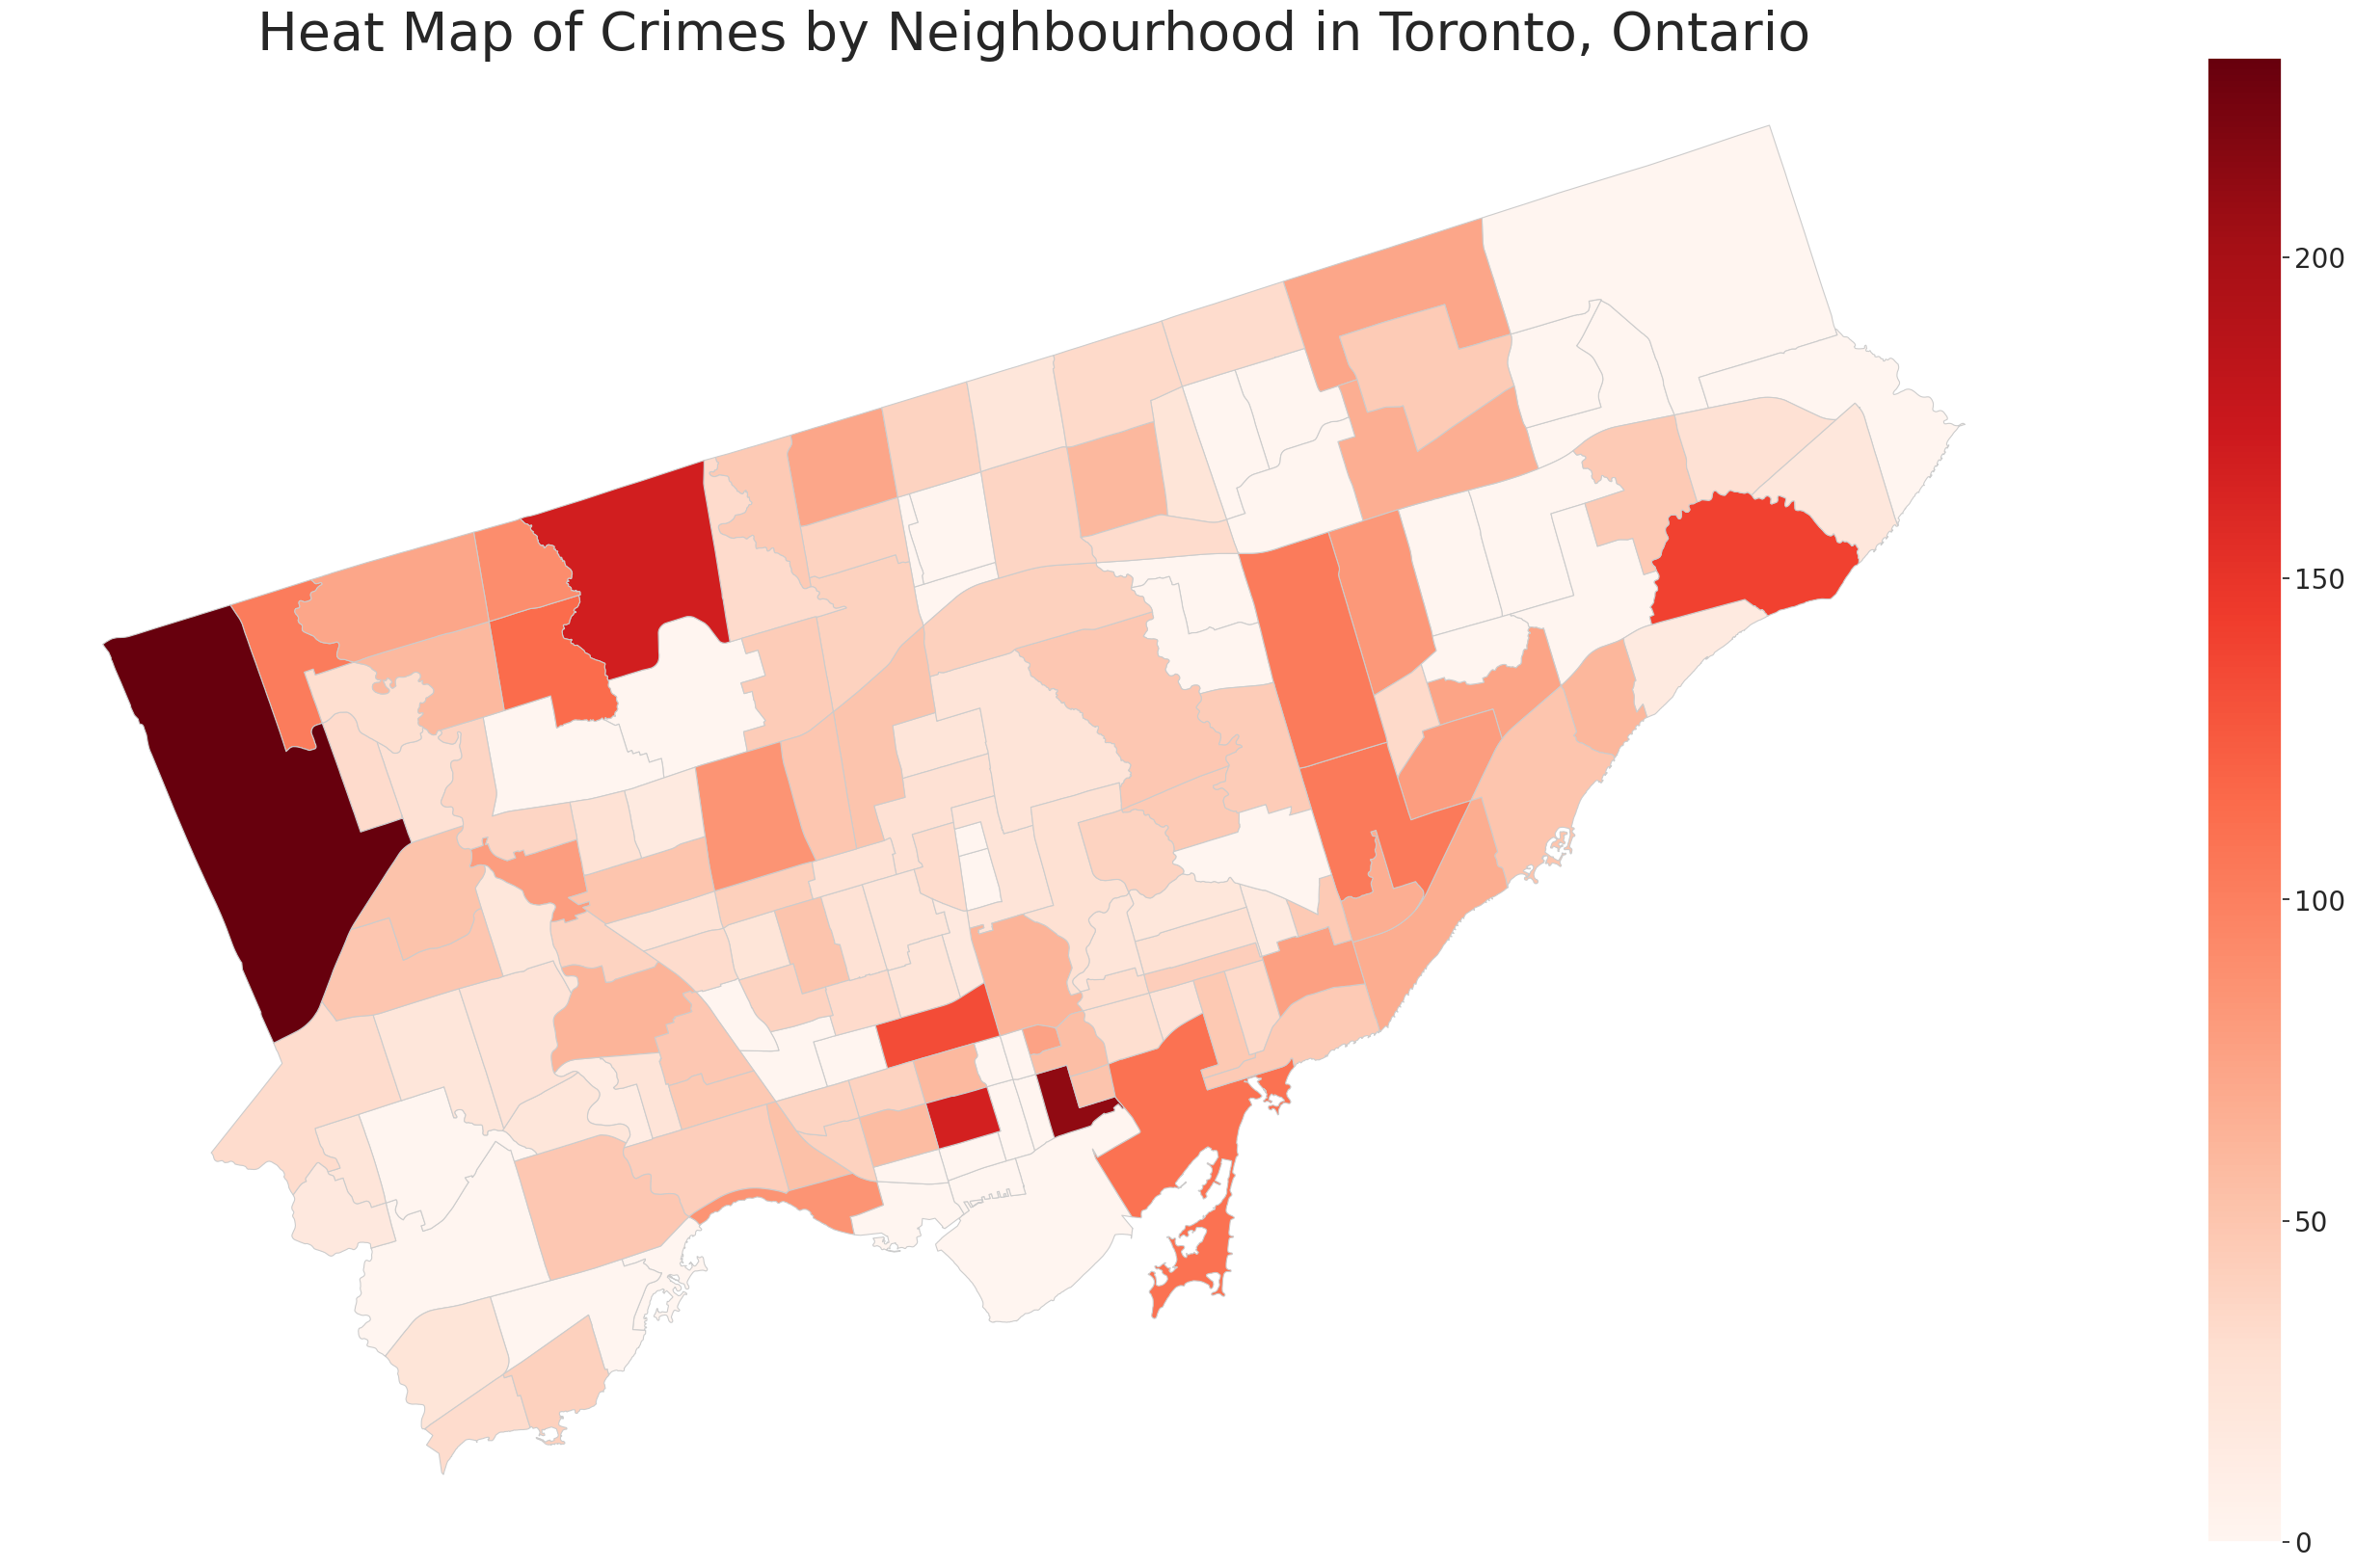

In [98]:
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Crimes by Neighbourhood in Toronto, Ontario', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'Reds'
vmin, vmax = 0, 231
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged.plot('count', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

In [99]:
merged.head(1)

FIELD_7  FIELD_1  FIELD_2   FIELD_3  FIELD_4  FIELD_5  \
0  south eglinton-davisville        1  2502366  26022881      0.0      174   

   FIELD_6                          FIELD_8  \
0      174  South Eglinton-Davisville (174)   

                                FIELD_9 FIELD_10  FIELD_11  \
0  Not an NIA or Emerging Neighbourhood        0  17824737   

                                            geometry  count  
0  POLYGON ((-79.38635 43.69783, -79.38623 43.697...    0.0

In [100]:
data.describe()

X             Y         Index_       ucr_code  \
count  2.765810e+05  2.765810e+05  276581.000000  276581.000000   
mean  -8.829477e+06  5.414751e+06  141516.053948    1702.152021   
std    2.798011e+05  1.716365e+05   81488.825917     326.071063   
min   -8.865398e+06  0.000000e+00       2.000000    1410.000000   
25%   -8.846720e+06  5.413098e+06   70930.000000    1430.000000   
50%   -8.838080e+06  5.419158e+06  141467.000000    1450.000000   
75%   -8.830322e+06  5.427050e+06  212128.000000    2120.000000   
max    0.000000e+00  5.442838e+06  301144.000000    2135.000000   

             ucr_ext   reportedyear    reportedday  reporteddayofyear  \
count  276581.000000  276581.000000  276581.000000      276581.000000   
mean      146.530586    2017.609626      15.750023         186.604492   
std        51.936549       2.262746       8.768153         103.878009   
min       100.000000    2014.000000       1.000000           1.000000   
25%       100.000000    2016.000000       8.000000          98.000000   
50%       100.000000    2018.000000      16.000000         189.000000   
75%       200.000000    2020.000000      23.000000         276.000000   
max       230.000000    2022.000000      31.000000         366.000000   

        reportedhour  occurrenceyear  ...  occurrencehour        Hood_ID  \
count  276581.000000   276581.000000  ...   276581.000000  276581.000000   
mean       12.820205     2017.576699  ...       12.618246      71.926821   
std         6.522236        2.251603  ...        7.232137      40.500783   
min         0.000000     2014.000000  ...        0.000000       1.000000   
25%         8.000000     2016.000000  ...        7.000000      35.000000   
50%        13.000000     2018.000000  ...       14.000000      75.000000   
75%        18.000000     2019.000000  ...       19.000000     107.000000   
max        23.000000     2021.000000  ...       23.000000     140.000000   

           Longitude       Latitude       ObjectId       pop_2016  \
count  276304.000000  276304.000000  276581.000000  276581.000000   
mean      -79.396059      43.706768  141516.482311   25292.666564   
std         0.103384       0.052621   81489.378814   12844.728815   
min       -79.639225      43.587092       1.000000    6577.000000   
25%       -79.471439      43.660830   70933.000000   15935.000000   
50%       -79.393889      43.700346  141463.000000   22372.000000   
75%       -79.324574      43.751440  212128.000000   31180.000000   
max       -79.123062      43.853752  301206.000000   65913.000000   

       pop_change_11-16  density_per_km2    surface_km2     count  
count     276581.000000    276581.000000  276581.000000  276581.0  
mean           0.069537      7183.967453       5.907411       1.0  
std            0.130836      5968.146815       6.223245       0.0  
min           -0.076000      1040.000000       0.420000       1.0  
25%           -0.002000      3565.000000       1.860000       1.0  
50%            0.022000      5395.000000       4.200000       1.0  
75%            0.080000      8943.000000       7.370000       1.0  
max            0.520000     44321.000000      36.890000       1.0  

[8 rows x 22 columns]

In [101]:
data.head()

X             Y  Index_ event_unique_id Division  \
0 -8.850398e+06  5.429359e+06     201  GO-20141273318      D31   
1 -8.818405e+06  5.436836e+06     202  GO-20141274349      D42   
2 -8.853791e+06  5.402071e+06     203  GO-20141274052      D22   
3 -8.832822e+06  5.419628e+06     204  GO-20141276966      D53   
4 -8.853452e+06  5.410706e+06     205  GO-20141274457      D22   

             occurrencedate            reporteddate  \
0 2014-01-03 05:00:00+00:00  2014/01/03 05:00:00+00   
1 2014-01-03 05:00:00+00:00  2014/01/03 05:00:00+00   
2 2014-01-03 05:00:00+00:00  2014/01/03 05:00:00+00   
3 2014-01-03 05:00:00+00:00  2014/01/03 05:00:00+00   
4 2014-01-03 05:00:00+00:00  2014/01/03 05:00:00+00   

                                       location_type premises_type  ucr_code  \
0                   Apartment (Rooming House, Condo)     Apartment      1430   
1  Single Home, House (Attach Garage, Cottage, Mo...         House      2120   
2                  Open Areas (Lakes, Parks, Rivers)       Outside      1430   
3  Other Commercial / Corporate Places (For Profi...    Commercial      2130   
4                                 Convenience Stores    Commercial      1610   

   ...   Latitude ObjectId  pop_2016 pop_change_11-16  density_per_km2  \
0  ...  43.766371        1     27593           -0.004             2086   
1  ...  43.814861        2     43794           -0.029             4948   
2  ...  43.589085        3     10084            0.047             4584   
3  ...  43.703212        4     21108            0.098             6787   
4  ...  43.645247        5     43965            0.154             2712   

   surface_km2 StatHoliday  vacation     crime_severity count  
0        13.23          NO        NO      violent_crime     1  
1         8.85          NO        NO  non_violent_crime     1  
2         2.20          NO        NO      violent_crime     1  
3         3.11          NO        NO  non_violent_crime     1  
4        16.21          NO        NO      violent_crime     1  

[5 rows x 38 columns]

In [102]:
### Plot the data based on the downloaded shape file - Toronto Map // March 16, 2023
### https://www.jiristodulka.com/post/toronto-crime/
###
import folium #maping crime on the map
from folium.plugins import HeatMap, MarkerCluster #making maping visually appealing
### Top N Criminal Neighbourhoods in Toronto 
top_N = data.groupby('Neighbourhood')[['mci_category']].count().sort_values(by=['mci_category'])
### Coordinates Criminal Neighbourhoods
map_data = data[['Neighbourhood', 'Latitude', 'Longitude']].drop_duplicates('Neighbourhood').set_index('Neighbourhood') \
    .join(top_N, how='inner')
map_data.sort_values(by=['mci_category'], ascending=False).head(10)

Latitude  Longitude  mci_category
Neighbourhood                                                        
Waterfront Communities-The Island  43.649131 -79.390756         10473
Church-Yonge Corridor              43.648627 -79.373824          9331
Bay Street Corridor                43.650868 -79.382626          8062
West Humber-Clairville             43.697108 -79.586443          7496
Moss Park                          43.653729 -79.373215          6853
York University Heights            43.766371 -79.504475          5468
Kensington-Chinatown               43.653346 -79.396125          5396
Downsview-Roding-CFB               43.719831 -79.513761          5344
Woburn                             43.773498 -79.230640          4989
West Hill                          43.764866 -79.184841          4539

In [103]:
x=data
map_data = map_data.dropna()

In [104]:
### Plot the data based on the downloaded shape file - Toronto Map // March 16, 2023
### https://www.jiristodulka.com/post/toronto-crime/
###
m = folium.Map(
    location=[43.702270, -79.366074],
    zoom_start=11
)
### Step 1: Clusters
cluster = MarkerCluster().add_to(m)
### Step 2: Clusters breaking into Markers
for x in map_data.iterrows():
    folium.Marker([x[1].Latitude, x[1].Longitude]).add_to(cluster)
### Step 3: Heat
max_crime = map_data['mci_category'].max() # max value as reference for the darkets shade
heat = HeatMap(map_data.values,
                min_opacity=0.2,
                max_val=max_crime,
                radius=30, blur=20, 
                max_zoom=11)
heat.add_to(m)
m

<ipython-input-104-c0fd1878ca57>:15: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  heat = HeatMap(map_data.values,


## 3.8 Correlations

The graphs above show that there is a clear seasonality to the crimes.
Crimes tend to be in an uptrend from the end of winter to fall. 
During the week, they rise slowly from monday and peak on friday.
During the day they start from 7AM (sunrise) and peak at midnight.
These patterns are observed for all the crimes category.

In [105]:
# ### Exploring the data to gain insigths
# ### Ploting Latitude + Longitude to visualize the data
# import plotly.express as px
# import xarray as xr
# # Load xarray from dataset included in the xarray tutorial
# airtemps = xr.tutorial.open_dataset('air_temperature').air.sel(lon=250.0)
# fig = px.imshow(airtemps.T, color_continuous_scale='RdBu_r', origin='lower')
# fig.show()

# 4 - Prepare the data for ML algorithm


In [106]:
data['mci_category'].unique()

array(['Assault', 'Break and Enter', 'Theft Over', 'Robbery',
       'Auto Theft'], dtype=object)

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276581 entries, 0 to 276580
Data columns (total 38 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   X                    276581 non-null  float64            
 1   Y                    276581 non-null  float64            
 2   Index_               276581 non-null  int64              
 3   event_unique_id      276581 non-null  object             
 4   Division             276581 non-null  object             
 5   occurrencedate       276581 non-null  datetime64[ns, UTC]
 6   reporteddate         276581 non-null  object             
 7   location_type        276581 non-null  object             
 8   premises_type        276581 non-null  object             
 9   ucr_code             276581 non-null  int64              
 10  ucr_ext              276581 non-null  int64              
 11  offence              276581 non-null  object             
 12  re

In [108]:
# Remove unecessary columns
# All the reported columns should be removed since we are only focusing on the occurence data
# X,Y is redundant with longitude and latitude
# ucr_code , ucr_ext not neccesary for our study
# offence is redudant with the target variable 
# location type is redundant with premises

data = data.drop(['Longitude', 'Latitude', 'Index_', 'event_unique_id', 'Division', 'reporteddate', 'location_type', 
                               'ucr_code', 'ucr_ext', 'reportedyear', 'reportedmonth', 'reportedday', 
                              'reporteddayofyear', 'reporteddayofweek', 'reportedhour', 'occurrencedayofyear', 
                              'offence', 'Neighbourhood', 'ObjectId','count',
                              'occurrencedate','occurrenceday','occurrenceyear'
                              ], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276581 entries, 0 to 276580
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    276581 non-null  float64
 1   Y                    276581 non-null  float64
 2   premises_type        276581 non-null  object 
 3   occurrencemonth      276581 non-null  object 
 4   occurrencedayofweek  276581 non-null  object 
 5   occurrencehour       276581 non-null  int64  
 6   mci_category         276581 non-null  object 
 7   Hood_ID              276581 non-null  int64  
 8   pop_2016             276581 non-null  int64  
 9   pop_change_11-16     276581 non-null  float64
 10  density_per_km2      276581 non-null  int64  
 11  surface_km2          276581 non-null  float64
 12  StatHoliday          276581 non-null  object 
 13  vacation             276581 non-null  object 
 14  crime_severity       276581 non-null  object 
dtypes: float64(4), in

In [109]:
data.columns.to_list()

['X',
 'Y',
 'premises_type',
 'occurrencemonth',
 'occurrencedayofweek',
 'occurrencehour',
 'mci_category',
 'Hood_ID',
 'pop_2016',
 'pop_change_11-16',
 'density_per_km2',
 'surface_km2',
 'StatHoliday',
 'vacation',
 'crime_severity']

In [110]:
# grouped_list=['Hood_ID',
#  'occurrencedate',
#  'occurrencemonth',
#  'occurrenceday',
#  'occurrencedayofweek',
#  #'mci_category',
#  'Longitude',
#  'Latitude',
#  #'count',
#  'pop_2016',
#  'pop_change_11-16',
#  'density_per_km2',
#  'surface_km2',
#  'StatHoliday',
#  'vacation']

# grouped_list

In [111]:
# enfore Hood_ID as categorical variable
data['Hood_ID'] = data['Hood_ID'] .astype('category')
# data['occurenceyear'] = data['occurenceyear'] .astype('category')
data['occurrencehour'] = data['occurrencehour'] .astype('category')

In [112]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.5 MB/s eta 0:00:00


In [113]:
# encoding the Hood_Id
import category_encoders as ce

# create an instance of BaseNEncoder with a base of 2
encoder = ce.BaseNEncoder(cols=['Hood_ID'], base=2)

# fit and transform the encoder on the data
data = encoder.fit_transform(data)
data.columns.to_list()

['X',
 'Y',
 'premises_type',
 'occurrencemonth',
 'occurrencedayofweek',
 'occurrencehour',
 'mci_category',
 'Hood_ID_0',
 'Hood_ID_1',
 'Hood_ID_2',
 'Hood_ID_3',
 'Hood_ID_4',
 'Hood_ID_5',
 'Hood_ID_6',
 'Hood_ID_7',
 'pop_2016',
 'pop_change_11-16',
 'density_per_km2',
 'surface_km2',
 'StatHoliday',
 'vacation',
 'crime_severity']

In [114]:
# # Aggregate the crime data by Hood_ID and occurrencedate to get the total number of crimes that occurred in each neighborhood on each day.

# import pandas as pd

# # Group the data by Hood_ID and occurrencedate and get the count of crimes in each group
# crime_count = data.groupby(grouped_list).size().reset_index(name='crime_count')

# # Drop the occurrencedate column as this column is now redudant
# crime_count = crime_count.drop('occurrencedate', axis=1)



# # Print the first 10 rows of the resulting DataFrame
# crime_count.head(10)


In [115]:
# crime_count.describe()

In [116]:
data.columns.to_list()


['X',
 'Y',
 'premises_type',
 'occurrencemonth',
 'occurrencedayofweek',
 'occurrencehour',
 'mci_category',
 'Hood_ID_0',
 'Hood_ID_1',
 'Hood_ID_2',
 'Hood_ID_3',
 'Hood_ID_4',
 'Hood_ID_5',
 'Hood_ID_6',
 'Hood_ID_7',
 'pop_2016',
 'pop_change_11-16',
 'density_per_km2',
 'surface_km2',
 'StatHoliday',
 'vacation',
 'crime_severity']

In [117]:
target='mci_category'
features=data.columns.to_list()
features.remove(target)
print(features)

['X', 'Y', 'premises_type', 'occurrencemonth', 'occurrencedayofweek', 'occurrencehour', 'Hood_ID_0', 'Hood_ID_1', 'Hood_ID_2', 'Hood_ID_3', 'Hood_ID_4', 'Hood_ID_5', 'Hood_ID_6', 'Hood_ID_7', 'pop_2016', 'pop_change_11-16', 'density_per_km2', 'surface_km2', 'StatHoliday', 'vacation', 'crime_severity']


#Pycaret

In [118]:
# import logging;logging.getLogger('pycaret').setLevel(logging.ERROR)

In [119]:
# # install pycaret
# !pip install pycaret


In [120]:
# # install multiple extras together

# !pip install pycaret[analysis,models,tuner]

In [121]:
# # import pycaret regression and init setup
# from pycaret.regression import *
# s1 = setup(crime_count, target = 'crime_count', session_id = 123,categorical_imputation='na')

# # compare baseline models
# best = compare_models()
# plot_model(best, plot = 'feature')

In [122]:
# from pycaret.classification import *


In [123]:
# model_data = data.drop('crime_severity', axis=1)
# s2 = setup(model_data, target='mci_category', session_id=123, categorical_imputation='na',fix_imbalance = True,use_gpu=True)

In [124]:
# # compare baseline models
# # best_model = compare_models(include=['rf', 'et', 'xgboost', 'catboost', 'lightgbm', 'gbc', 'ada', 'ridge', 'dt', 'knn', 'lr'])
# best_model = compare_models(include=['rf','xgboost', 'dt', 'knn', 'lr'])

In [125]:
# plot_model(best_model, plot = 'feature')

In [126]:
# # tune the hyperparameters of the best model using Random Search
# tuned_model = tune_model(best_model, optimize = 'Accuracy', n_iter = 50, choose_better = True)

# # evaluate the tuned model using 10-fold cross-validation
# cv_scores = cross_val_score(tuned_model, X, y, cv=10, scoring='accuracy')
# print('Cross-validation scores:', cv_scores)
# print('Mean CV score:', cv_scores.mean())

In [127]:
# evaluate_model(best_model)

# 5 - Select a Model and Train it

**Imports**

**Helper functions**

In [128]:
def check_data_balance(series, style="seaborn-pastel"):
    """
    Checks the balance of a categorical target variable by plotting 
    the distribution of classes in the target variable using a pie chart.

    Parameters:
    series (pandas Series): The target variable.
    style (str, optional): The plot style. Defaults to "seaborn-pastel".

    Returns:
    None
    """
    with plt.style.context(style):
        unique = series.value_counts()
        display(unique)
        plt.pie(unique, explode=[0.05]*len(unique), labels=unique.index, autopct='%1.1f%%')


In [129]:
def preprocess_data(X_train, X_test, y_train, y_test, columns_numerical, columns_categorical):
    """
    Preprocesses the numerical and categorical features of a dataset using a ColumnTransformer.

    Parameters:
    X_train (pd.DataFrame or np.ndarray): the training feature matrix
    X_test (pd.DataFrame or np.ndarray): the testing feature matrix
    y_train (pd.Series or np.ndarray): the training target vector
    y_test (pd.Series or np.ndarray): the testing target vector
    columns_numerical (list): the column names or indices of the numerical features
    columns_categorical (list): the column names or indices of the categorical features

    Returns:
    tuple: a tuple of the transformed feature matrices and target vectors for the training and testing sets, and the fitted preprocessor
    """
    # create preprocessing pipelines for numerical and categorical features
    num_pipeline = Pipeline([('scaler', StandardScaler())])
    cat_pipeline = Pipeline([('encoder', OneHotEncoder(drop='first'))])
    preprocessor = ColumnTransformer([('num', num_pipeline, columns_numerical),
                                      ('cat', cat_pipeline, columns_categorical)])
    
    # Fit the preprocessor on X_train and y_train once
    X_train_transformed = preprocessor.fit_transform(X_train)
    y_train_transformed = LabelEncoder().fit_transform(y_train)
    
    # Transform X_test and y_test using the fitted preprocessor
    X_test_transformed = preprocessor.transform(X_test)
    y_test_transformed = LabelEncoder().fit_transform(y_test)
    
    return X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed, preprocessor

In [130]:
def fit_model(X_train_transformed, y_train_transformed, model):
    """
    Fits a machine learning model on a transformed training set using a pipeline.
    
    Parameters:
    X_train_transformed (pd.DataFrame or np.ndarray): the transformed training feature matrix
    y_train_transformed (pd.Series or np.ndarray): the transformed training target vector
    model (sklearn estimator): the model to fit
    
    Returns:
    pipeline (sklearn pipeline): the pipeline used to fit the model
    """
    # create pipeline for the model
    # pipeline = Pipeline([('classifier', model)])

    # Train the model on the transformed training set
    model.fit(X_train_transformed, y_train_transformed)
    
    return model


In [131]:
def evaluate_model_with_cv(X_test_transformed, y_test,model):
    """
    Evaluates a model using cross-validation on a transformed testing set.
    
    Parameters:
    model (sklearn estimator): the model to evaluate
    X_test_transformed (pd.DataFrame or np.ndarray): the transformed testing feature matrix
    y_test (pd.Series or np.ndarray): the testing target vector
    
    Returns:
    None
    """
    model_name = type(model).__name__
    #cv_results = cross_val_score(model, X_test_transformed, y_test, cv=StratifiedKFold(n_splits=10))
    cv_results = cross_val_score(model, X_test_transformed, y_test, cv=10)

    print(f'{model_name.capitalize()} - Cross-validation scores: {cv_results}')
    print(f'{model_name.capitalize()} - Cross-validation mean score: {cv_results.mean():.3f}')
    print(f'{model_name.capitalize()} - Cross-validation standard deviation: {cv_results.std():.3f}')
    
    y_pred = cross_val_predict(model, X_test_transformed, y_test, cv=10)
    print(f'{model_name.capitalize()} - Classification Report (CV):\n', classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    sns.set(font_scale=1.4)  # adjust font size
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name.capitalize()} - Confusion Matrix (CV)')
    plt.show()


***Defining the data***

In [167]:
# Data
model_data = data.drop('crime_severity', axis=1)
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276581 entries, 0 to 276580
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   X                    276581 non-null  float64 
 1   Y                    276581 non-null  float64 
 2   premises_type        276581 non-null  object  
 3   occurrencemonth      276581 non-null  object  
 4   occurrencedayofweek  276581 non-null  object  
 5   occurrencehour       276581 non-null  category
 6   mci_category         276581 non-null  object  
 7   Hood_ID_0            276581 non-null  int64   
 8   Hood_ID_1            276581 non-null  int64   
 9   Hood_ID_2            276581 non-null  int64   
 10  Hood_ID_3            276581 non-null  int64   
 11  Hood_ID_4            276581 non-null  int64   
 12  Hood_ID_5            276581 non-null  int64   
 13  Hood_ID_6            276581 non-null  int64   
 14  Hood_ID_7            276581 non-null  int64   
 15  

***Define the features = categorical + numerical features***

In [168]:
# Defining the model features
# define list of numerical and categorical features

TARGET = "mci_category"
columns_predictors = [col for col in model_data.columns if col not in [TARGET]]
# 'Hood_ID' feature is already encoded
columns_categorical = [
'premises_type',
'occurrencemonth',
'occurrencedayofweek',
'occurrencehour',
# 'mci_category',
'StatHoliday',
'vacation'
]

columns_numerical = [col for col in columns_predictors if col not in columns_categorical]

In [169]:
columns_predictors

['X',
 'Y',
 'premises_type',
 'occurrencemonth',
 'occurrencedayofweek',
 'occurrencehour',
 'Hood_ID_0',
 'Hood_ID_1',
 'Hood_ID_2',
 'Hood_ID_3',
 'Hood_ID_4',
 'Hood_ID_5',
 'Hood_ID_6',
 'Hood_ID_7',
 'pop_2016',
 'pop_change_11-16',
 'density_per_km2',
 'surface_km2',
 'StatHoliday',
 'vacation']

***Define X (data) and y (target)***

In [170]:
X = model_data.drop('mci_category', axis=1)
y = model_data[TARGET]

# X = model_data
# display(X)

***Training and testing split***

In [171]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

In [179]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(221264, 20)
(221264,)
(55317, 20)
(55317,)


In [172]:
X_train
# X_train.columns.to_list()
# y_train

X             Y premises_type occurrencemonth  \
205457 -8.842220e+06  5.415556e+06   Educational        December   
136461 -8.842204e+06  5.411380e+06    Commercial        February   
27776  -8.819767e+06  5.427899e+06    Commercial        November   
200526 -8.825954e+06  5.419929e+06       Outside        November   
180035 -8.838769e+06  5.412661e+06    Commercial             May   
...              ...           ...           ...             ...   
38709  -8.838034e+06  5.411346e+06       Outside           April   
33925  -8.822514e+06  5.419811e+06     Apartment        February   
62287  -8.855413e+06  5.419639e+06     Apartment        December   
110990 -8.839267e+06  5.412533e+06     Apartment             May   
197347 -8.837115e+06  5.412857e+06     Apartment         October   

       occurrencedayofweek occurrencehour  Hood_ID_0  Hood_ID_1  Hood_ID_2  \
205457          Tuesday                10          0          1          1   
136461          Friday                  3          0          0          1   
27776           Friday                 17          0          0          1   
200526          Friday                 20          0          1          0   
180035          Friday                 21          0          1          0   
...                    ...            ...        ...        ...        ...   
38709           Sunday                  3          0          1          0   
33925           Sunday                 11          0          1          0   
62287           Tuesday                 9          0          0          0   
110990          Tuesday                21          0          1          1   
197347          Saturday                3          0          0          0   

        Hood_ID_3  Hood_ID_4  Hood_ID_5  Hood_ID_6  Hood_ID_7  pop_2016  \
205457          1          0          0          0          0     14349   
136461          1          0          0          1          0     15559   
27776           1          1          1          0          0     53485   
200526          0          0          0          0          1     26984   
180035          1          1          1          1          0     17945   
...           ...        ...        ...        ...        ...       ...   
38709           1          1          1          1          0     17945   
33925           1          0          0          1          0     22291   
62287           1          1          0          0          1     22000   
110990          1          1          0          0          1      7607   
197347          1          0          0          0          0     25797   

        pop_change_11-16  density_per_km2  surface_km2 StatHoliday vacation  
205457             0.026             8541         1.68          NO       NO  
136461             0.291            12859         1.21          NO       NO  
27776              0.003             4345        12.31          NO       NO  
200526             0.089             3632         7.43          NO       NO  
180035            -0.030            11806         1.52          NO       NO  
...                  ...              ...          ...         ...      ...  
38709             -0.030            11806         1.52          NO       NO  
33925              0.020             3765         5.92          NO       NO  
62287              0.013             4356         5.05          NO       NO  
110990            -0.022             5395         1.41          NO       NO  
197347             0.333            14097         1.83          NO       NO  

[221264 rows x 20 columns]

***Feature Scaling and transformation***

In [173]:
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed, preprocessor=preprocess_data(X_train, X_test, y_train, y_test, columns_numerical, columns_categorical)

In [178]:
print(X_train_transformed.shape)
print(y_train_transformed.shape)
print(X_test_transformed.shape)
print(y_test_transformed.shape)

(221264, 76)
(221264,)
(55317, 76)
(55317,)


## 5.1 Logistic regression

In [139]:
# # Uncomment this section if you want to train the model yourself
# # Create a simple logistic regression model
# model1 = LogisticRegression(multi_class='multinomial')
# model1=fit_model(X_train_transformed, y_train_transformed, model1)

*In order to re-run the notebook faster, the model will be saved once trained and it will be shared alongside this notebook. <br>
The code cell above has been commented out to speed up the execution of the notebook.<br>
In case the user of this notebook want to train the model, please uncomment the section above and train the model again.*

In [140]:
import joblib

In [144]:
# joblib.dump(model1, 'model1.joblib')

In [145]:
# Load the saved model
model1 = joblib.load('model1.joblib')

In [146]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

Logisticregression - Cross-validation scores: [0.57357195 0.56995662 0.57845264 0.57537961 0.57176428 0.5824295
 0.57049892 0.57060206 0.57150606 0.56879407]
Logisticregression - Cross-validation mean score: 0.573
Logisticregression - Cross-validation standard deviation: 0.004


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logisticregression - Classification Report (CV):
                  precision    recall  f1-score   support

        Assault       0.59      0.89      0.71     29728
     Auto Theft       0.47      0.24      0.32      7201
Break and Enter       0.50      0.31      0.38     11203
        Robbery       0.67      0.00      0.00      5377
     Theft Over       0.00      0.00      0.00      1808

       accuracy                           0.57     55317
      macro avg       0.45      0.29      0.28     55317
   weighted avg       0.55      0.57      0.50     55317



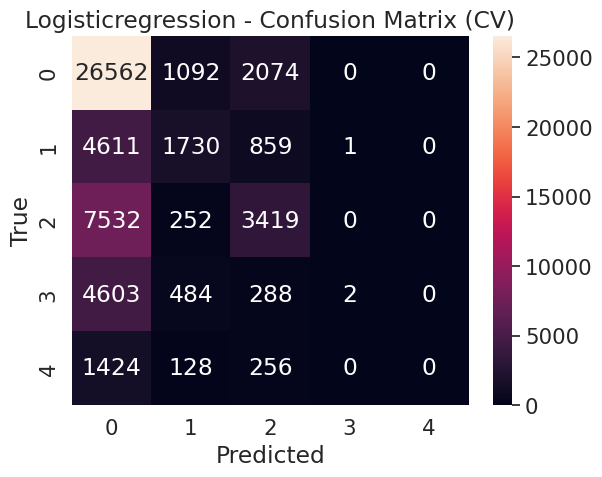

In [147]:
evaluate_model_with_cv(X_test_transformed, y_test,model1)

In [148]:
# from sklearn.model_selection import GridSearchCV

# # define parameter grid
# param_grid = {
#     'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'C': [0.1, 1, 10, 100]
# }

# # create grid search object
# grid_search = GridSearchCV(model1, param_grid, cv=5, n_jobs=-1)

# # fit grid search object to data
# grid_search.fit(X_train_transformed, y_train)

# # print best hyperparameters
# print(grid_search.best_params_)

In [149]:
# /usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan 0.57468454        nan 0.57393429 0.57495118 0.57478396
#  0.57414219 0.57398401        nan        nan        nan        nan
#  0.57533082        nan 0.57388458 0.57387102        nan 0.57529015
#         nan 0.57392977 0.57528562 0.57529919 0.57402016 0.5739117
#         nan        nan        nan        nan 0.57533082        nan
#  0.57389362 0.57387554        nan 0.57528563        nan 0.57390718
#  0.57526303 0.57528563 0.57389362 0.57387554        nan        nan
#         nan        nan 0.57533082        nan 0.57388458 0.57388458
#         nan 0.57528111        nan 0.57389362 0.57531726 0.57529015
#  0.5738891  0.5738891         nan        nan        nan        nan
#  0.57533082        nan 0.57390718 0.57387554]
#   warnings.warn(
# /usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
#   warnings.warn(
# /usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
#   warnings.warn(
# {'C': 0.1, 'penalty': 'none', 'solver': 'lbfgs'}

In [150]:
# scoring_metrics = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}
# grid_search = HalvingGridSearchCV(model1, param_grid, cv=5, n_jobs=-1, scoring=scoring_metrics, factor=2, max_resources='auto', resource='n_samples', min_resources=None)

## 5.2 Decision tree

In [151]:
from sklearn.tree import DecisionTreeClassifier

In [152]:
# # Uncomment this section if you want to train the model yourself
# # Create a decision tree classifier
# model2 = DecisionTreeClassifier()

# # Fit model on transformed train set
# model2=fit_model(X_train_transformed, y_train_transformed, model2)

*In order to re-run the notebook faster, the model will be saved once trained and it will be shared alongside this notebook. <br>
The code cell above has been commented out to speed up the execution of the notebook.<br>
In case the user of this notebook want to train the model, please uncomment the section above and train the model again.*

In [153]:
# # Save the model
# joblib.dump(model2, 'model2.joblib')

In [154]:
# Load the saved model
model2 = joblib.load('model2.joblib')

Decisiontreeclassifier - Cross-validation scores: [0.50524223 0.51446132 0.52349964 0.49475777 0.50976139 0.50668836
 0.52494577 0.50515278 0.51111915 0.50949195]
Decisiontreeclassifier - Cross-validation mean score: 0.511
Decisiontreeclassifier - Cross-validation standard deviation: 0.008
Decisiontreeclassifier - Classification Report (CV):
                  precision    recall  f1-score   support

        Assault       0.64      0.65      0.64     29728
     Auto Theft       0.36      0.36      0.36      7201
Break and Enter       0.44      0.43      0.43     11203
        Robbery       0.25      0.26      0.26      5377
     Theft Over       0.07      0.07      0.07      1808

       accuracy                           0.51     55317
      macro avg       0.35      0.35      0.35     55317
   weighted avg       0.51      0.51      0.51     55317



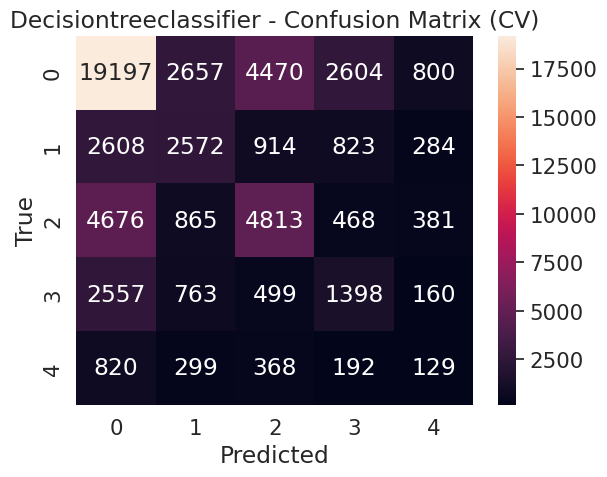

In [155]:
# Evaluate model
evaluate_model_with_cv(X_test_transformed, y_test,model2)

## 5.3 XGBoost

In [156]:
# Import XGBoost
import xgboost as xgb

In [157]:
# # Uncomment this section if you want to train the model yourself
# # Create an XGBoost classifier
# model3 = xgb.XGBClassifier()

# # Fit model on transformed train set
# model3=fit_model(X_train_transformed, y_train_transformed, model3)

*In order to re-run the notebook faster, the model will be saved once trained and it will be shared alongside this notebook. <br>
The code cell above has been commented out to speed up the execution of the notebook.<br>
In case the user of this notebook want to train the model, please uncomment the section above and train the model again.*

In [158]:
# # Save the model
# joblib.dump(model3, 'model3.joblib')

In [159]:
# Load the saved model
model3 = joblib.load('model3.joblib')

***Lesson learned:***

*XGBoost does not have a built-in way to handle multi-class classification with string labels, so it requires that the labels be encoded into integers beforehand.
When evaluating the XGBoost model, you need to ensure that the labels are encoded into integers, so that the model can output integer predictions for each class.*

Xgbclassifier - Cross-validation scores: [0.60177151 0.60412148 0.61225597 0.60394071 0.60394071 0.60502531
 0.60538684 0.59862593 0.6045923  0.59790273]
Xgbclassifier - Cross-validation mean score: 0.604
Xgbclassifier - Cross-validation standard deviation: 0.004
Xgbclassifier - Classification Report (CV):
               precision    recall  f1-score   support

           0       0.63      0.87      0.73     29728
           1       0.51      0.35      0.42      7201
           2       0.56      0.41      0.48     11203
           3       0.39      0.06      0.11      5377
           4       0.20      0.01      0.02      1808

    accuracy                           0.60     55317
   macro avg       0.46      0.34      0.35     55317
weighted avg       0.56      0.60      0.55     55317



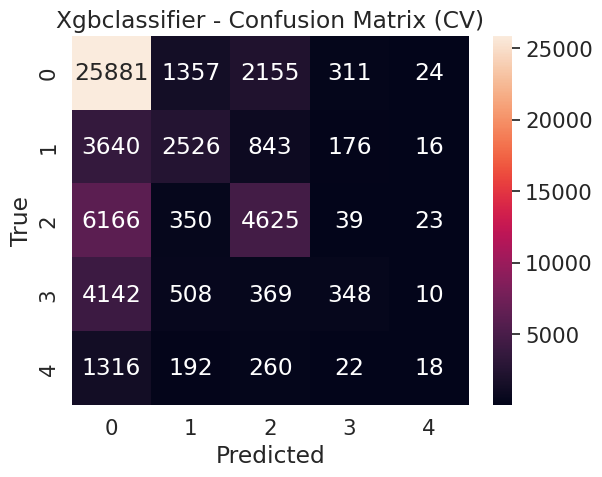

In [160]:
# encode target variable y to integer labels
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)

# evaluate model
evaluate_model_with_cv(X_test_transformed, y_test_encoded, model3)

**Out of all the three model, XGboost seems to be better with the highest F1-score (0.73) and the second highest precision (0.64). Also majority class 'Assault' seems to be giving better results with the model while the prediction of the other classes are worse than a random coin flip (50% chance).**

## 5.4 Dimensionality reduction

In [215]:
# # Get numerical features names
# numerical_feature_names = columns_numerical

# # Get categorical features names from preprocessor object
# categorical_transformer = preprocessor.named_transformers_['cat']
# one_hot_encoder = categorical_transformer.named_steps['encoder']
# transformed_categorical_feature_names = one_hot_encoder.get_feature_names_out(columns_categorical)

# # Combine numerical and categorical feature names
# transformed_column_names = np.concatenate([numerical_feature_names, transformed_categorical_feature_names])

# # Print the transformed column names
# print(transformed_column_names)

['X' 'Y' 'Hood_ID_0' 'Hood_ID_1' 'Hood_ID_2' 'Hood_ID_3' 'Hood_ID_4'
 'Hood_ID_5' 'Hood_ID_6' 'Hood_ID_7' 'pop_2016' 'pop_change_11-16'
 'density_per_km2' 'surface_km2' 'premises_type_Commercial'
 'premises_type_Educational' 'premises_type_House' 'premises_type_Other'
 'premises_type_Outside' 'premises_type_Transit' 'occurrencemonth_August'
 'occurrencemonth_December' 'occurrencemonth_February'
 'occurrencemonth_January' 'occurrencemonth_July' 'occurrencemonth_June'
 'occurrencemonth_March' 'occurrencemonth_May' 'occurrencemonth_November'
 'occurrencemonth_October' 'occurrencemonth_September'
 'occurrencedayofweek_Monday    ' 'occurrencedayofweek_Saturday  '
 'occurrencedayofweek_Sunday    ' 'occurrencedayofweek_Thursday  '
 'occurrencedayofweek_Tuesday   ' 'occurrencedayofweek_Wednesday '
 'occurrencehour_1' 'occurrencehour_2' 'occurrencehour_3'
 'occurrencehour_4' 'occurrencehour_5' 'occurrencehour_6'
 'occurrencehour_7' 'occurrencehour_8' 'occurrencehour_9'
 'occurrencehour_10' 'occ

In [196]:
# # Retrieve feature importance scores
# booster = model3.get_booster()
# weight_importance = booster.get_score(importance_type='weight')
# gain_importance = booster.get_score(importance_type='gain')
# cover_importance = booster.get_score(importance_type='cover')

# # Convert dictionaries to pandas Series
# weight_series = pd.Series(weight_importance, name='Weight Importance')
# gain_series = pd.Series(gain_importance, name='Gain Importance')
# cover_series = pd.Series(cover_importance, name='Cover Importance')

# # # Print feature importances
# # print("Weight importance:", weight_importance)
# # print("Gain importance:", gain_importance)
# # print("Cover importance:", cover_importance)

# # Combine the Series into a DataFrame
# importance_df = pd.concat([weight_series, gain_series, cover_series], axis=1)

# # Use the union of feature indices from all importance dictionaries as index
# all_features = set(weight_importance.keys()) | set(gain_importance.keys()) | set(cover_importance.keys())
# importance_df = importance_df.reindex(all_features)
# importance_df.index.name = 'Feature Index'

In [199]:
# # Print the DataFrame
# print(importance_df)

               Weight Importance  Gain Importance  Cover Importance
Feature Index                                                      
f22                        162.0         3.270097       3502.377197
f62                         11.0         2.859346      75312.312500
f64                         25.0         2.828118      19144.250000
f45                        118.0         9.265059      13032.547852
f28                        207.0         2.356207       2600.534912
...                          ...              ...               ...
f63                         16.0         2.428202      11093.001953
f31                        273.0         2.134508        735.720398
f75                        134.0         2.691632       2117.004883
f35                        232.0         2.525370        346.215729
f59                        165.0        13.797983       7265.606934

[76 rows x 3 columns]


In [207]:
# # Get the actual feature names from the booster
# feature_names =model3.feature_types
# print(feature_names)

In [ ]:

# # Create a dictionary mapping encoded feature names to actual feature names
# encoded_to_actual = {f'f{index}': name for index, name in enumerate(feature_names)}

# # Replace the feature index with the actual feature names
# importance_df.index = importance_df.index.map(encoded_to_actual)

# # Rename the index
# importance_df.index.name = 'Feature Name'

# # Print the DataFrame
# print(importance_df)

{'f0': 5106.0, 'f1': 4966.0, 'f2': 52.0, 'f3': 136.0, 'f4': 122.0, 'f5': 119.0, 'f6': 134.0, 'f7': 95.0, 'f8': 116.0, 'f9': 132.0, 'f10': 1105.0, 'f11': 1141.0, 'f12': 1136.0, 'f13': 729.0, 'f14': 685.0, 'f15': 254.0, 'f16': 412.0, 'f17': 371.0, 'f18': 509.0, 'f19': 118.0, 'f20': 139.0, 'f21': 170.0, 'f22': 162.0, 'f23': 182.0, 'f24': 125.0, 'f25': 180.0, 'f26': 187.0, 'f27': 166.0, 'f28': 207.0, 'f29': 164.0, 'f30': 180.0, 'f31': 273.0, 'f32': 316.0, 'f33': 378.0, 'f34': 262.0, 'f35': 232.0, 'f36': 248.0, 'f37': 197.0, 'f38': 186.0, 'f39': 164.0, 'f40': 112.0, 'f41': 62.0, 'f42': 74.0, 'f43': 85.0, 'f44': 103.0, 'f45': 118.0, 'f46': 105.0, 'f47': 107.0, 'f48': 182.0, 'f49': 124.0, 'f50': 133.0, 'f51': 109.0, 'f52': 110.0, 'f53': 133.0, 'f54': 132.0, 'f55': 128.0, 'f56': 153.0, 'f57': 180.0, 'f58': 154.0, 'f59': 165.0, 'f60': 13.0, 'f61': 30.0, 'f62': 11.0, 'f63': 16.0, 'f64': 25.0, 'f65': 12.0, 'f66': 9.0, 'f67': 23.0, 'f68': 113.0, 'f69': 63.0, 'f70': 20.0, 'f71': 21.0, 'f72': 43.0, 

In [164]:
# # Lets use RFECV (recursive feature elimination with cross-validation)
# # to reduce the amount of features in our xgboost model3.

# # Scorer for F1 score since this is the metric we want to improve
# f1_scorer = make_scorer(f1_score,average='macro')

# # Stratified K-fold
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # create RFECV object with F1 score as scoring metric
# rfecv = RFECV(estimator=model1, step=1, cv=cv, scoring=f1_scorer, min_features_to_select=10)

# # Fit the rfecv object on the transformed training set
# rfecv.fit(X_train_transformed, y_train_transformed)

# # select columns that were selected by RFECV
# selected_feature_names = original_feature_names[rfecv.support_]

# # print selected features and their rankings
# print("Selected encoded features:", X_train_transformed.columns[rfecv.support_])
# print("Selected original features:", selected_feature_names)
# print("Feature rankings:", rfecv.ranking_)

KeyboardInterrupt: ignored

# 6 - Clustering

# 7 - Fine-tuning the model

# 8 - Results and Model Performance 

# 9 - Conclusions

In [161]:
# !pip install autoflake

In [162]:
# !autoflake --remove-unused-imports -i 

In [163]:
# cuda dfs
# import pandas as pd
# import cudf
# import cuml
# from sklearn.preprocessing import LabelEncoder

# # Load the data using Pandas
# train_data = pd.read_csv('train.csv')
# test_data = pd.read_csv('test.csv')

# # Split the data into features and target
# X_train = train_data.drop(['target'], axis=1)
# y_train = train_data['target']
# X_test = test_data.drop(['target'], axis=1)
# y_test = test_data['target']

# # Preprocess the data using your existing function
# X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed, preprocessor = preprocess_data(X_train, X_test, y_train, y_test, columns_numerical, columns_categorical)

# # Convert the data to cuDF format
# X_train_cudf = cudf.DataFrame.from_pandas(X_train_transformed)
# X_test_cudf = cudf.DataFrame.from_pandas(X_test_transformed)
# y_train_cudf = cudf.Series(y_train_transformed)
# y_test_cudf = cudf.Series(y_test_transformed)

# # Create a linear regression model
# lr = cuml.LinearRegression()

# # Train the model on the data
# lr.fit(X_train_cudf, y_train_cudf)

# # Make predictions on the test data
# predictions_cudf = lr.predict(X_test_cudf)

# # Convert predictions back to Pandas DataFrame
# predictions_df = predictions_cudf.to_pandas()
